# Scaler Clustering Case Study

Gautam Naik (gautamnaik1994@gmail.com)   
Github link: https://github.com/gautamnaik1994/ScalerJobDataClusteringCaseStudy


[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/gautamnaik1994/ScalerJobDataClusteringCaseStudy/blob/main/notebooks/CaseStudy.ipynb?flush_cache=true)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gautamnaik1994/ScalerJobDataClusteringCaseStudy/blob/main/notebooks/CaseStudy.ipynb)



**Business Problem**

Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. 

We will be using following techniques to cluster the data:

*   John Hopkins Test to check clustering tendency
*   Manual Clustering
*   Unsupervised Clustering - K- means, Hierarchical Clustering

After this post cluster analysis will be done to understand the clusters and their characteristics. Polar plots will be used to compare the clusters characteristics.
UMAP and PCA will be used to visualize the clusters in 2D space.


**Dataset columns**

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| ‘Unnamed 0’         | Index of the dataset                                                        |
| Email_hash          | Anonymised Personal Identifiable Information (PII)                          |
| Company_hash        | This represents an anonymized identifier for the company, which is the current employer of the learner. |
| orgyear             | Employment start date                                                       |
| CTC                 | Current CTC                                                                 |
| Job_position        | Job profile in the company                                                  |
| CTC_updated_year    | Year in which CTC got updated (Yearly increments, Promotions)               |



In [1]:
import pandas as pd
import numpy as np
import polars as pl
import duckdb as db
import re


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearnex import patch_sklearn
patch_sklearn()

import umap

from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import fastcluster

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter

sns.set_theme(style="whitegrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2024-09-26 10:38:54.305954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Sanity Check

In [204]:
df=pl.read_csv("../data/raw/data.csv", has_header=True)

In [5]:
df.head()

shape: (5, 7)
┌─────┬───────────────────┬──────────────────┬─────────┬─────────┬──────────────┬──────────────────┐
│     ┆ company_hash      ┆ email_hash       ┆ orgyear ┆ ctc     ┆ job_position ┆ ctc_updated_year │
│ --- ┆ ---               ┆ ---              ┆ ---     ┆ ---     ┆ ---          ┆ ---              │
│ i64 ┆ str               ┆ str              ┆ f64     ┆ i64     ┆ str          ┆ f64              │
╞═════╪═══════════════════╪══════════════════╪═════════╪═════════╪══════════════╪══════════════════╡
│ 0   ┆ atrgxnnt xzaxv    ┆ 6de0a4417d18ab14 ┆ 2016.0  ┆ 1100000 ┆ Other        ┆ 2020.0           │
│     ┆                   ┆ 334c3f43397fc1…  ┆         ┆         ┆              ┆                  │
│ 1   ┆ qtrxvzwt xzegwgbb ┆ b0aaf1ac138b53cb ┆ 2018.0  ┆ 449999  ┆ FullStack    ┆ 2019.0           │
│     ┆ rxbxnta           ┆ 6e039ba2c3d660…  ┆         ┆         ┆ Engineer     ┆                  │
│ 2   ┆ ojzwnvwnxw vx     ┆ 4860c670bcd48fb9 ┆ 2015.0  ┆ 2000000 ┆ Backend      ┆ 2020.0           │
│     ┆                   ┆ 6c02a4b0ae3608…  ┆         ┆         ┆ Engineer     ┆                  │
│ 3   ┆ ngpgutaxv         ┆ effdede7a2e7c2af ┆ 2017.0  ┆ 700000  ┆ Backend      ┆ 2019.0           │
│     ┆                   ┆ 664c8a31d93463…  ┆         ┆         ┆ Engineer     ┆                  │
│ 4   ┆ qxen sqghu        ┆ 6ff54e709262f55c ┆ 2017.0  ┆ 1400000 ┆ FullStack    ┆ 2019.0           │
│     ┆                   ┆ b999a1c1db8436…  ┆         ┆         ┆ Engineer     ┆                  │
└─────┴───────────────────┴──────────────────┴─────────┴─────────┴──────────────┴──────────────────┘

In [6]:
df.describe()

shape: (9, 8)
┌────────────┬────────────┬────────────┬────────────┬───────────┬──────────┬───────────┬───────────┐
│ statistic  ┆            ┆ company_ha ┆ email_hash ┆ orgyear   ┆ ctc      ┆ job_posit ┆ ctc_updat │
│ ---        ┆ ---        ┆ sh         ┆ ---        ┆ ---       ┆ ---      ┆ ion       ┆ ed_year   │
│ str        ┆ f64        ┆ ---        ┆ str        ┆ f64       ┆ f64      ┆ ---       ┆ ---       │
│            ┆            ┆ str        ┆            ┆           ┆          ┆ str       ┆ f64       │
╞════════════╪════════════╪════════════╪════════════╪═══════════╪══════════╪═══════════╪═══════════╡
│ count      ┆ 205843.0   ┆ 205799     ┆ 205843     ┆ 205757.0  ┆ 205843.0 ┆ 153281    ┆ 205843.0  │
│ null_count ┆ 0.0        ┆ 44         ┆ 0          ┆ 86.0      ┆ 0.0      ┆ 52562     ┆ 0.0       │
│ mean       ┆ 103273.941 ┆ null       ┆ null       ┆ 2014.8827 ┆ 2.2717e6 ┆ null      ┆ 2019.6282 │
│            ┆ 786        ┆            ┆            ┆ 5         ┆          ┆           ┆ 31        │
│ std        ┆ 59741.3064 ┆ null       ┆ null       ┆ 63.571115 ┆ 1.1801e7 ┆ null      ┆ 1.325104  │
│            ┆ 84         ┆            ┆            ┆           ┆          ┆           ┆           │
│ min        ┆ 0.0        ┆ 0          ┆ 0000328803 ┆ 0.0       ┆ 2.0      ┆  SDE 2    ┆ 2015.0    │
│            ┆            ┆            ┆ 6a44374976 ┆           ┆          ┆           ┆           │
│            ┆            ┆            ┆ 948c327f24 ┆           ┆          ┆           ┆           │
│            ┆            ┆            ┆ …          ┆           ┆          ┆           ┆           │
│ 25%        ┆ 51519.0    ┆ null       ┆ null       ┆ 2013.0    ┆ 530000.0 ┆ null      ┆ 2019.0    │
│ 50%        ┆ 103151.0   ┆ null       ┆ null       ┆ 2016.0    ┆ 950000.0 ┆ null      ┆ 2020.0    │
│ 75%        ┆ 154993.0   ┆ null       ┆ null       ┆ 2018.0    ┆ 1.7e6    ┆ null      ┆ 2021.0    │
│ max        ┆ 206922.0   ┆ zzzbzb     ┆ ffffa3eb35 ┆ 20165.0   ┆ 1.0002e9 ┆ technolog ┆ 2021.0    │
│            ┆            ┆            ┆ 75f43b86d9 ┆           ┆          ┆ y analyst ┆           │
│            ┆            ┆            ┆ 86911463dc ┆           ┆          ┆           ┆           │
│            ┆            ┆            ┆ …          ┆           ┆          ┆           ┆           │
└────────────┴────────────┴────────────┴────────────┴───────────┴──────────┴───────────┴───────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>


- From above table we can see that 2 lakh entries are there in the dataset.
- There are 44 missing values in company hash and 86 missing values in orgyear.
- The minimum value of ctc is 2.0 which can be an error or an outlier.
- The minimum value of orgyear is 0.0 which is not possible.
- The max value of orgyear is 20165.0 which is not possible.


In [206]:
df["email_hash"].unique().count(), df["company_hash"].unique().count()

(153443, 37299)

In [7]:
df.null_count()

shape: (1, 7)
┌─────┬──────────────┬────────────┬─────────┬─────┬──────────────┬──────────────────┐
│     ┆ company_hash ┆ email_hash ┆ orgyear ┆ ctc ┆ job_position ┆ ctc_updated_year │
│ --- ┆ ---          ┆ ---        ┆ ---     ┆ --- ┆ ---          ┆ ---              │
│ u32 ┆ u32          ┆ u32        ┆ u32     ┆ u32 ┆ u32          ┆ u32              │
╞═════╪══════════════╪════════════╪═════════╪═════╪══════════════╪══════════════════╡
│ 0   ┆ 44           ┆ 0          ┆ 86      ┆ 0   ┆ 52562        ┆ 0                │
└─────┴──────────────┴────────────┴─────────┴─────┴──────────────┴──────────────────┘

# Data Cleaning and Preprocessing

In [8]:
df.filter(df["orgyear"].is_null())

shape: (86, 7)
┌────────┬─────────────────┬─────────────────┬─────────┬─────────┬────────────────┬────────────────┐
│        ┆ company_hash    ┆ email_hash      ┆ orgyear ┆ ctc     ┆ job_position   ┆ ctc_updated_ye │
│ ---    ┆ ---             ┆ ---             ┆ ---     ┆ ---     ┆ ---            ┆ ar             │
│ i64    ┆ str             ┆ str             ┆ f64     ┆ i64     ┆ str            ┆ ---            │
│        ┆                 ┆                 ┆         ┆         ┆                ┆ f64            │
╞════════╪═════════════════╪═════════════════╪═════════╪═════════╪════════════════╪════════════════╡
│ 2333   ┆ xgmgn           ┆ c737ceb66c7f0ce ┆ null    ┆ 170000  ┆ Other          ┆ 2020.0         │
│        ┆ ntwyzgrgsxto    ┆ 37c2fce087003aa ┆         ┆         ┆                ┆                │
│        ┆ ucn rna         ┆ …               ┆         ┆         ┆                ┆                │
│ 2562   ┆ tj              ┆ 25edac17c77f6f0 ┆ null    ┆ 860000  ┆ Data Analyst   ┆ 2020.0         │
│        ┆                 ┆ edeafb86f7a7844 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 3122   ┆ ft tdwtr        ┆ c402eba160abf4e ┆ null    ┆ 600000  ┆ Support        ┆ 2020.0         │
│        ┆                 ┆ 5b5f72af775fc98 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 3365   ┆ fyxntyvn lq     ┆ 38bd913564fa983 ┆ null    ┆ 800000  ┆ null           ┆ 2021.0         │
│        ┆                 ┆ cd4fb7799e4027d ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 4010   ┆ nxamxn          ┆ f9c1d0e623046d4 ┆ null    ┆ 900000  ┆ null           ┆ 2020.0         │
│        ┆ ogrhnxgzo       ┆ 45a705bc39007f0 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ …      ┆ …               ┆ …               ┆ …       ┆ …       ┆ …              ┆ …              │
│ 179152 ┆ ohbg rgsxw      ┆ 60c2f0c5b719160 ┆ null    ┆ 3600000 ┆ null           ┆ 2020.0         │
│        ┆                 ┆ 991e78a7c00b709 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 179445 ┆ vr bhrrv sqghu  ┆ 87febfabdc6689a ┆ null    ┆ 600000  ┆ Android        ┆ 2019.0         │
│        ┆                 ┆ 29e33ff30d7cd40 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 182509 ┆ fgqpxzs vo v    ┆ bf814503a271c88 ┆ null    ┆ 1200000 ┆ Product        ┆ 2019.0         │
│        ┆ eqttrvzwtq      ┆ 32095892856e176 ┆         ┆         ┆ Designer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 195074 ┆ sgavaaj         ┆ 638ffe59e3f96d6 ┆ null    ┆ 1800000 ┆ Frontend       ┆ 2018.0         │
│        ┆                 ┆ c2e182979680d46 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206515 ┆ vhngsqxa        ┆ 3fa8de870da01d8 ┆ null    ┆ 2400000 ┆ null           ┆ 2020.0         │
│        ┆                 ┆ 63abba8eb6a8ae3 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
└────────┴─────────────────┴─────────────────┴─────────┴─────────┴────────────────┴────────────────┘

**Mean and Mode Imputation**

In [15]:
df=df.with_columns(
    pl.col("company_hash").fill_null(df["company_hash"].max()),
    pl.col("orgyear").fill_null(df["orgyear"].mean()).cast(pl.Int64),
)

shape: (205_843, 7)
┌────────┬─────────────────┬─────────────────┬─────────┬─────────┬────────────────┬────────────────┐
│        ┆ company_hash    ┆ email_hash      ┆ orgyear ┆ ctc     ┆ job_position   ┆ ctc_updated_ye │
│ ---    ┆ ---             ┆ ---             ┆ ---     ┆ ---     ┆ ---            ┆ ar             │
│ i64    ┆ str             ┆ str             ┆ i64     ┆ i64     ┆ str            ┆ ---            │
│        ┆                 ┆                 ┆         ┆         ┆                ┆ f64            │
╞════════╪═════════════════╪═════════════════╪═════════╪═════════╪════════════════╪════════════════╡
│ 0      ┆ atrgxnnt xzaxv  ┆ 6de0a4417d18ab1 ┆ 2016    ┆ 1100000 ┆ Other          ┆ 2020.0         │
│        ┆                 ┆ 4334c3f43397fc1 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 1      ┆ qtrxvzwt        ┆ b0aaf1ac138b53c ┆ 2018    ┆ 449999  ┆ FullStack      ┆ 2019.0         │
│        ┆ xzegwgbb        ┆ b6e039ba2c3d660 ┆         ┆         ┆ Engineer       ┆                │
│        ┆ rxbxnta         ┆ …               ┆         ┆         ┆                ┆                │
│ 2      ┆ ojzwnvwnxw vx   ┆ 4860c670bcd48fb ┆ 2015    ┆ 2000000 ┆ Backend        ┆ 2020.0         │
│        ┆                 ┆ 96c02a4b0ae3608 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 3      ┆ ngpgutaxv       ┆ effdede7a2e7c2a ┆ 2017    ┆ 700000  ┆ Backend        ┆ 2019.0         │
│        ┆                 ┆ f664c8a31d93463 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 4      ┆ qxen sqghu      ┆ 6ff54e709262f55 ┆ 2017    ┆ 1400000 ┆ FullStack      ┆ 2019.0         │
│        ┆                 ┆ cb999a1c1db8436 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ …      ┆ …               ┆ …               ┆ …       ┆ …       ┆ …              ┆ …              │
│ 206918 ┆ vuurt xzw       ┆ 70027b728c8ee90 ┆ 2008    ┆ 220000  ┆ null           ┆ 2019.0         │
│        ┆                 ┆ 1fe979533ed94ff ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206919 ┆ husqvawgb       ┆ 7f7292ffad724eb ┆ 2017    ┆ 500000  ┆ null           ┆ 2020.0         │
│        ┆                 ┆ be9ca860f515245 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206920 ┆ vwwgrxnt        ┆ cb25cc7304e9a24 ┆ 2021    ┆ 700000  ┆ null           ┆ 2021.0         │
│        ┆                 ┆ facda7f5567c792 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206921 ┆ zgn vuurxwvmrt  ┆ fb46a1a2752f5f6 ┆ 2019    ┆ 5100000 ┆ null           ┆ 2019.0         │
│        ┆                 ┆ 52ce634f6178d05 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206922 ┆ bgqsvz onvzrtj  ┆ 0bcfc1d05f2e8dc ┆ 2014    ┆ 1240000 ┆ null           ┆ 2016.0         │
│        ┆                 ┆ 4147743a1313aa7 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
└────────┴─────────────────┴─────────────────┴─────────┴─────────┴────────────────┴────────────────┘

In [91]:
df=df.drop_nulls(subset=["job_position"])
df = df.drop("")
df=df.unique()
df = df.with_columns(
    df["orgyear"].cast(pl.Int32),
    df["ctc_updated_year"].cast(pl.Int32)
)

**Unique email and company values**

In [92]:
df["email_hash"].unique().count(), df["company_hash"].unique().count()

(133146, 34203)

**Fixing the job position column**

In [93]:
df = df.with_columns(pl.col("job_position").fill_null(pl.lit("unknown")))
df = df.with_columns(df["job_position"].str.to_lowercase())
df = df.with_columns(df["job_position"].str.replace("-", " "))
df = df.with_columns(df["job_position"].str.replace(r"[^a-zA-Z0-9 ]", ""))
df = df.with_columns(df["job_position"].str.replace("\)", ""))
df = df.with_columns(df["job_position"].str.replace("\(", " "))
df = df.with_columns_seq(
    df["job_position"]
    .str.replace("ii", "2")
    .str.replace(r" i\b", " 1")
    .str.replace("iii", "3")
    # .str.replace(r"", " 1")
    # .str.replace(r"(\b\w+)i\b", r"{1} i")
    .str.replace("sr ", "senior ")
    .str.replace("jr ", "junior ")
)

df = df.with_columns_seq(
    df["job_position"]
    .str.replace("front end", "frontend")
    .str.replace("back end", "backend")
    .str.replace("full stack", "fullstack")
    .str.replace("sde2", "sde 2")
    .str.replace("sde3", "sde 3")
    .str.replace("se4", "se 4")
    .str.replace("2i", "2")
    .str.replace(r"\br d\b", "rd")
    .str.replace(r"enginner|engineers|engineeer|engineet|eingineer", "engineer")
    .str.replace(r"engg\b", "engineer")
    .str.replace("applications", "application")
    .str.replace(r"dev\b", "developer")
    .str.replace(r"devloper|develloper", "developer")
    .str.replace("consulant", "consultant")
    .str.replace(r"others\b", "other")
    .str.replace(" of ", " ")
    .str.replace("tech ", "technical ")
    .str.replace_all(r"development(\w+)",r"development ${1}")
    # .str.replace(r"\b\d+\b", "unknown")
    # .str.replace(r"\b\w\b", "unknown")
    # .str.replace(r"\.", "unknown")
    # replace empty strings with unknown
    # .fill_null("unknown")
)

df = df.with_columns(df["job_position"].str.replace("  ", " "))
df = df.with_columns(df["job_position"].str.strip_chars())

**Spellings Mistakes Correction**

In [94]:
words = df["job_position"].str.split(" ").explode()
WORDS = Counter(words.to_list())

In [95]:
# https://norvig.com/spell-correct.html

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [96]:
def correct_words(sentence):
    return " ".join([correction(word) for word in sentence.split()])

def clean_jobs(word):
    if len(word) <= 1:
        return "unknown"
    try:
        float(word)
        return "unknown"
    except ValueError:
        return word

def replace_words(sentence):
    unemployed = ["na","no", "no job", "not applicable", "not employed", "not working", "null", "none", "now iam not working waiting for job"]
    if sentence in unemployed:
        return "unemployed"
    else:
        return sentence

In [97]:
df = df.with_columns(pl.col('job_position').map_elements(correct_words).alias("job_position"))
df = df.with_columns(pl.col('job_position').map_elements(clean_jobs).alias("job_position"))
df = df.with_columns(pl.col('job_position').map_elements(replace_words).alias("job_position"))

In [98]:
df=df.unique()

**Org Year Fix**

In [99]:
df.filter(pl.col("orgyear") < 1970).sort("orgyear", descending=True)

shape: (26, 6)
┌───────────────────┬───────────────────┬─────────┬─────────┬───────────────────┬──────────────────┐
│ company_hash      ┆ email_hash        ┆ orgyear ┆ ctc     ┆ job_position      ┆ ctc_updated_year │
│ ---               ┆ ---               ┆ ---     ┆ ---     ┆ ---               ┆ ---              │
│ str               ┆ str               ┆ i32     ┆ i64     ┆ str               ┆ i32              │
╞═══════════════════╪═══════════════════╪═════════╪═════════╪═══════════════════╪══════════════════╡
│ ovst xznvwwn      ┆ 3da3c964efe7a5db0 ┆ 1900    ┆ 3170000 ┆ engineering       ┆ 2019             │
│ ogenfvqt ucn rna  ┆ f63e91be25391…    ┆         ┆         ┆ leadership        ┆                  │
│ wgxznqxmt ntwy    ┆ a9393ceb6f438669a ┆ 201     ┆ 3500000 ┆ product manager   ┆ 2017             │
│ exzntwy ctznhqt   ┆ 12e2f5632d515…    ┆         ┆         ┆                   ┆                  │
│ wxowg cxatg       ┆ c3cce99fc54361b5c ┆ 200     ┆ 3000000 ┆ engineering       ┆ 2019             │
│ ntwyzgrgsxto      ┆ 213f8043505d2…    ┆         ┆         ┆ leadership        ┆                  │
│ xzaxv…            ┆                   ┆         ┆         ┆                   ┆                  │
│ vzshrvq atcqrgutq ┆ 1978da71c14333352 ┆ 91      ┆ 400000  ┆ devops engineer   ┆ 2021             │
│                   ┆ d051bfb605490…    ┆         ┆         ┆                   ┆                  │
│ bvzyvnnvz         ┆ e725ad631cdc4c57a ┆ 83      ┆ 730000  ┆ backend engineer  ┆ 2019             │
│ voogwxvnto        ┆ 354f59c98b644…    ┆         ┆         ┆                   ┆                  │
│ …                 ┆ …                 ┆ …       ┆ …       ┆ …                 ┆ …                │
│ wyvqstugxzn       ┆ a1da4f131e2efea24 ┆ 0       ┆ 1850000 ┆ backend engineer  ┆ 2019             │
│                   ┆ f6d64c6651972…    ┆         ┆         ┆                   ┆                  │
│ wyvqstugxzn       ┆ a1da4f131e2efea24 ┆ 0       ┆ 1850000 ┆ fullstack         ┆ 2019             │
│                   ┆ f6d64c6651972…    ┆         ┆         ┆ engineer          ┆                  │
│ cvrhtej ogrhnxgzo ┆ a184e9709d7a9adfc ┆ 0       ┆ 1300000 ┆ backend engineer  ┆ 2020             │
│                   ┆ 1e2d500770e92…    ┆         ┆         ┆                   ┆                  │
│ rgsfvqa           ┆ b511b17a1aaaa822c ┆ 0       ┆ 1600000 ┆ frontend engineer ┆ 2021             │
│                   ┆ 6b5d6a04498ff…    ┆         ┆         ┆                   ┆                  │
│ bxznb xzw         ┆ 5bbebf13d3b3edc49 ┆ 0       ┆ 700000  ┆ fullstack         ┆ 2019             │
│                   ┆ 7bc5e24d1ab54…    ┆         ┆         ┆ engineer          ┆                  │
└───────────────────┴───────────────────┴─────────┴─────────┴───────────────────┴──────────────────┘

In [100]:
df=df.with_columns(
    pl.when(pl.col("orgyear") < 1970).then(pl.col("ctc_updated_year")-1).otherwise(pl.col("orgyear")).alias("orgyear")
)

In [101]:
df.filter(df["orgyear"]> df["ctc_updated_year"]).sort("orgyear", descending=True)

shape: (5_016, 6)
┌───────────────────┬───────────────────┬─────────┬─────────┬───────────────────┬──────────────────┐
│ company_hash      ┆ email_hash        ┆ orgyear ┆ ctc     ┆ job_position      ┆ ctc_updated_year │
│ ---               ┆ ---               ┆ ---     ┆ ---     ┆ ---               ┆ ---              │
│ str               ┆ str               ┆ i32     ┆ i64     ┆ str               ┆ i32              │
╞═══════════════════╪═══════════════════╪═════════╪═════════╪═══════════════════╪══════════════════╡
│ lu bgqsgz         ┆ 799dff77b331bfac0 ┆ 2204    ┆ 2160000 ┆ data scientist    ┆ 2018             │
│                   ┆ 4cf005935acf7…    ┆         ┆         ┆                   ┆                  │
│ hufgqp            ┆ e4705330da8333687 ┆ 2031    ┆ 1100000 ┆ fullstack         ┆ 2019             │
│                   ┆ 80aae561afc93…    ┆         ┆         ┆ engineer          ┆                  │
│ hufgqp            ┆ e4705330da8333687 ┆ 2031    ┆ 1100000 ┆ backend engineer  ┆ 2019             │
│                   ┆ 80aae561afc93…    ┆         ┆         ┆                   ┆                  │
│ hufgqp            ┆ e4705330da8333687 ┆ 2031    ┆ 1100000 ┆ other             ┆ 2019             │
│                   ┆ 80aae561afc93…    ┆         ┆         ┆                   ┆                  │
│ phrxkv            ┆ 3394674bb6bb1de62 ┆ 2031    ┆ 1500000 ┆ backend engineer  ┆ 2020             │
│                   ┆ 89e931853fa0b…    ┆         ┆         ┆                   ┆                  │
│ …                 ┆ …                 ┆ …       ┆ …       ┆ …                 ┆ …                │
│ mvqwrvjo          ┆ f2da8af7e11da5d6c ┆ 2016    ┆ 1100000 ┆ pune              ┆ 2015             │
│ wgqugqvnt mvzpxzs ┆ 7e73670fbe8e0…    ┆         ┆         ┆                   ┆                  │
│ bgmonvw           ┆ 648e830d20e1053c5 ┆ 2016    ┆ 900000  ┆ fullstack         ┆ 2015             │
│                   ┆ 4e8bb2a82f96f…    ┆         ┆         ┆ engineer          ┆                  │
│ nvnv wgzohrnvzwj  ┆ cd681b4485116e1a4 ┆ 2016    ┆ 420000  ┆ backend engineer  ┆ 2015             │
│ otqcxwto          ┆ 6c144f2d87ebc…    ┆         ┆         ┆                   ┆                  │
│ svrvdtogrhnxgzo   ┆ c6789faa51e7f32f1 ┆ 2016    ┆ 1100000 ┆ backend engineer  ┆ 2015             │
│                   ┆ 9908baaeb5cb1…    ┆         ┆         ┆                   ┆                  │
│ ovu               ┆ b652f5720ca7489ea ┆ 2016    ┆ 930000  ┆ fullstack         ┆ 2015             │
│                   ┆ 586203e1b24fd…    ┆         ┆         ┆ engineer          ┆                  │
└───────────────────┴───────────────────┴─────────┴─────────┴───────────────────┴──────────────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above table we can see that around 8k candidates have org_year greater than ctc updated year which is not possible.
- Need to fix this by subtracting 1 from ctc updated year.

In [102]:
df = df.with_columns(
    orgyear=pl.when(pl.col("orgyear") > pl.col("ctc_updated_year"))
    .then(pl.col("ctc_updated_year") - 1 )
    .otherwise(pl.col("orgyear"))
)

**CTC Fix**

In [103]:
df.filter(df["ctc"] <= 100)

shape: (3, 6)
┌─────────────────────┬──────────────────────┬─────────┬─────┬──────────────────┬──────────────────┐
│ company_hash        ┆ email_hash           ┆ orgyear ┆ ctc ┆ job_position     ┆ ctc_updated_year │
│ ---                 ┆ ---                  ┆ ---     ┆ --- ┆ ---              ┆ ---              │
│ str                 ┆ str                  ┆ i32     ┆ i64 ┆ str              ┆ i32              │
╞═════════════════════╪══════════════════════╪═════════╪═════╪══════════════════╪══════════════════╡
│ xzntqcxtfmxn        ┆ 3505b02549ebe2c95840 ┆ 2014    ┆ 2   ┆ backend engineer ┆ 2019             │
│                     ┆ ac6f0a3556…          ┆         ┆     ┆                  ┆                  │
│ uqvpqxnx voogwxvnto ┆ 8786759b95d673466e94 ┆ 2020    ┆ 24  ┆ other            ┆ 2020             │
│                     ┆ f62f1b15e4…          ┆         ┆     ┆                  ┆                  │
│ ftm ongqt           ┆ 512f761579fb116e215c ┆ 2016    ┆ 25  ┆ android engineer ┆ 2018             │
│                     ┆ abc9821c7f…          ┆         ┆     ┆                  ┆                  │
└─────────────────────┴──────────────────────┴─────────┴─────┴──────────────────┴──────────────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above table it is fair to assume that CTC is in lakhs.
- These rows CTCs should be multiplied by 100000.

In [104]:
df = df.with_columns(
    ctc=pl.when(pl.col("ctc") < 100)
    .then(pl.col("ctc") * 100000 )
    .otherwise(pl.col("ctc"))
)

In [105]:
position_count_df=df.group_by("job_position").agg(pl.count("job_position").alias("count")).sort("count", descending=True)
position_count_df

shape: (813, 2)
┌────────────────────────────────┬───────┐
│ job_position                   ┆ count │
│ ---                            ┆ ---   │
│ str                            ┆ u32   │
╞════════════════════════════════╪═══════╡
│ backend engineer               ┆ 43532 │
│ fullstack engineer             ┆ 25873 │
│ other                          ┆ 18060 │
│ frontend engineer              ┆ 10413 │
│ engineering leadership         ┆ 6867  │
│ …                              ┆ …     │
│ professional services engineer ┆ 1     │
│ networking                     ┆ 1     │
│ member technical staff level 2 ┆ 1     │
│ senior chat associate          ┆ 1     │
│ software engineer iv           ┆ 1     │
└────────────────────────────────┴───────┘

**Using top position from each company to fill unknown values of job position**

In [108]:
# filtered_df = df.filter(
#     (pl.col("job_position") != 'unknown') & (pl.col("company_hash").is_not_null())
# )
# grouped_df = filtered_df.group_by(["company_hash", "job_position"]).agg(
#     pl.count().alias("count")
# )
# ranked_df = grouped_df.with_columns(
#     pl.col("count").rank("min").over("company_hash").reverse().alias("rank")
# )
# top_position_df = ranked_df.filter(pl.col("rank") ==1).select("company_hash", "job_position").sort("company_hash").unique()

top_position_df = db.sql(""" 
  with cte as (
      select company_hash, job_position, count(*) as cnt,
            row_number() over (partition by company_hash order by count(*) desc) as rn
      from df 
      where job_position != 'unknown' 
        and company_hash in (
            select distinct company_hash 
            from df 
            where job_position = 'unknown' 
              and company_hash is not null
        )
      group by company_hash, job_position
  )
  select company_hash, job_position 
  from cte 
  where rn = 1
""").pl()

In [109]:
df=df.join(top_position_df, on="company_hash", how="left").unique()
df = df.with_columns(pl.col("job_position_right").fill_null(pl.lit("unknown")))
df=df.with_columns(
    pl.when(pl.col("job_position") == "unknown")
    .then(pl.col("job_position_right"))
    .otherwise(pl.col("job_position")).alias("job_position")
)
df = df.drop(["job_position_right"])

In [110]:
df["job_position"].value_counts(sort=True)

shape: (813, 2)
┌─────────────────────────────────┬───────┐
│ job_position                    ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ backend engineer                ┆ 43534 │
│ fullstack engineer              ┆ 25872 │
│ other                           ┆ 18063 │
│ frontend engineer               ┆ 10413 │
│ engineering leadership          ┆ 6867  │
│ …                               ┆ …     │
│ senior sofware engineer         ┆ 1     │
│ any technical                   ┆ 1     │
│ senior webmethods developer     ┆ 1     │
│ senior technical manager        ┆ 1     │
│ oracle apps technical consulta… ┆ 1     │
└─────────────────────────────────┴───────┘

In [111]:
df.columns

['company_hash',
 'email_hash',
 'orgyear',
 'ctc',
 'job_position',
 'ctc_updated_year']

In [117]:
# df_unique=db.sql("""
#     with cte as (
#         select company_hash, job_position, email_hash, orgyear, ctc, ctc_updated_year,
#         row_number() over (partition by email_hash order by orgyear desc, ctc_updated_year desc, ctc desc) as rn
#         from df
#     )
#     select company_hash, job_position, email_hash, orgyear, ctc, ctc_updated_year from cte where rn = 1
# """).pl()

In [42]:
df=df.unique()

In [119]:
df.write_parquet("../data/cleaned/data_duplicates.parquet")
df_unique.write_parquet("../data/cleaned/data_de_duplicates.parquet")

# Feature Engineering

In [35]:
df=pl.read_parquet("../data/cleaned/data_duplicates.parquet")

**Creating Years of Experience Column**

In [37]:
df["orgyear"].max(), df["ctc_updated_year"].max()

(2021, 2021)

Using 2022 as the current year as 2021 is the last year in the dataset.

In [38]:
df=df.with_columns(
    yoe = 2022 - pl.col("orgyear")
)

**Extracting unique candidates from the dataset because of duplicate values**

In [39]:
df=db.sql("""
    with cte as (
        select company_hash, job_position, email_hash, orgyear, ctc, ctc_updated_year, yoe,
        row_number() over (partition by email_hash order by orgyear desc, ctc_updated_year desc, ctc desc) as rn,
        -- avg(ctc) over (partition by email_hash) as avg_ctc,
        count(*) over (partition by email_hash) as num_jobs,
        (max(ctc) over (partition by email_hash) - min(ctc) over (partition by email_hash))/min(ctc) over (partition by email_hash) as growth
        from df
    )
    select * from cte where rn = 1 order by num_jobs desc
""").pl().drop(["rn"])

In [45]:
df["yoe"].min(), df["yoe"].max()

(1, 52)

In [46]:
df=df.with_columns(
    ctc_to_exp_ratio = pl.col("ctc") / (pl.col("yoe")*12*1000),
)

In [47]:
df

shape: (133_146, 10)
┌──────────────┬─────────────┬─────────────┬─────────┬───┬─────┬──────────┬──────────┬─────────────┐
│ company_hash ┆ job_positio ┆ email_hash  ┆ orgyear ┆ … ┆ yoe ┆ num_jobs ┆ growth   ┆ ctc_to_exp_ │
│ ---          ┆ n           ┆ ---         ┆ ---     ┆   ┆ --- ┆ ---      ┆ ---      ┆ ratio       │
│ str          ┆ ---         ┆ str         ┆ i32     ┆   ┆ i32 ┆ i64      ┆ f64      ┆ ---         │
│              ┆ str         ┆             ┆         ┆   ┆     ┆          ┆          ┆ f64         │
╞══════════════╪═════════════╪═════════════╪═════════╪═══╪═════╪══════════╪══════════╪═════════════╡
│ wgcxvb       ┆ data        ┆ 3e5e49daa55 ┆ 2018    ┆ … ┆ 4   ┆ 9        ┆ 0.041475 ┆ 23.541667   │
│ ntwyzgrgsxto ┆ analyst     ┆ 27a6d5a3359 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 9b238bf9…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ ihvrwgbb     ┆ devops      ┆ 6842660273f ┆ 2017    ┆ … ┆ 5   ┆ 9        ┆ 0.2      ┆ 40.0        │
│              ┆ engineer    ┆ 70e9aa23902 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 6ba33bfe…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ nyt a t oyvf ┆ sdet        ┆ c0eb1290616 ┆ 2013    ┆ … ┆ 9   ┆ 8        ┆ 0.513158 ┆ 21.296296   │
│ sqghu        ┆             ┆ 75da412b0de ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ b15871dd…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ oxej         ┆ other       ┆ bbace3cc586 ┆ 2018    ┆ … ┆ 4   ┆ 8        ┆ 0.090909 ┆ 15.0        │
│ ntwyzgrgsxto ┆             ┆ 400bbc65765 ┆         ┆   ┆     ┆          ┆          ┆             │
│ rxbxnta      ┆             ┆ bc6a16b7…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ cvrhtbgbtznh ┆ other       ┆ 298528ce316 ┆ 2018    ┆ … ┆ 4   ┆ 8        ┆ 0.028571 ┆ 15.0        │
│ b            ┆             ┆ 0cc761e4dc3 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 7a07337e…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ …            ┆ …           ┆ …           ┆ …       ┆ … ┆ …   ┆ …        ┆ …        ┆ …           │
│ so rvm       ┆ devops      ┆ 6d5acda3aa5 ┆ 2014    ┆ … ┆ 8   ┆ 1        ┆ 0.0      ┆ 8.333333    │
│              ┆ engineer    ┆ 0c201f07b60 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ ae58209a…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ kxrxzsg      ┆ android     ┆ 6d5f2d2389d ┆ 2014    ┆ … ┆ 8   ┆ 1        ┆ 0.0      ┆ 26.041667   │
│              ┆ engineer    ┆ 92e2dee3dbc ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 13d7ad2c…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ r3           ┆ other       ┆ 6d60bc429c1 ┆ 2017    ┆ … ┆ 5   ┆ 1        ┆ 0.0      ┆ 8.833333    │
│ ntwyzgrgsxto ┆             ┆ a5a542a3db7 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 2ea45e70…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ vrnqvz       ┆ backend     ┆ 6d6d29d229e ┆ 2013    ┆ … ┆ 9   ┆ 1        ┆ 0.0      ┆ 11.574074   │
│ vqxwtzn      ┆ engineer    ┆ cc859d2238f ┆         ┆   ┆     ┆          ┆          ┆             │
│ tqonfyxrt    ┆             ┆ 5b756022…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ ntwyz…       ┆             ┆             ┆         ┆   ┆     ┆          ┆          ┆             │
│ qxcxsg       ┆ other       ┆ 6d8712d2fe8 ┆ 2017    ┆ … ┆ 5   ┆ 1        ┆ 0.0      ┆ 6.0         │
│              ┆             ┆ 732a1e88296 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 44fb7a62…   ┆         ┆   ┆     ┆          ┆          ┆             │
└──────────────┴─────────────┴─────────────┴─────────┴───┴─────┴──────────┴──────────┴─────────────┘

**Creating individual groups for manual clustering**

In [48]:
g1 = df.group_by(["company_hash", "job_position", "yoe"]).agg(
    pl.mean("ctc").alias("mean_ctc"),
    pl.median("ctc").alias("median_ctc"),
    pl.max("ctc").alias("max_ctc"),
    pl.min("ctc").alias("min_ctc"),
    pl.count("ctc").alias("count"),
).sort("count", descending=True)
g1

g2 = df.group_by(["company_hash", "job_position"]).agg(
    pl.mean("ctc").alias("mean_ctc"),
    pl.median("ctc").alias("median_ctc"),
    pl.max("ctc").alias("max_ctc"),
    pl.min("ctc").alias("min_ctc"),
    pl.count("ctc").alias("count"),
).sort(["count"], descending=True)
g2

g3 = df.group_by(["company_hash"]).agg(
    pl.mean("ctc").alias("mean_ctc"),
    pl.median("ctc").alias("median_ctc"),
    pl.max("ctc").alias("max_ctc"),
    pl.min("ctc").alias("min_ctc"),
    pl.count("ctc").alias("count"),
).sort("count", descending=True)
g3

shape: (84_222, 8)
┌────────────────┬────────────────┬─────┬───────────────┬────────────┬───────────┬─────────┬───────┐
│ company_hash   ┆ job_position   ┆ yoe ┆ mean_ctc      ┆ median_ctc ┆ max_ctc   ┆ min_ctc ┆ count │
│ ---            ┆ ---            ┆ --- ┆ ---           ┆ ---        ┆ ---       ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ i32 ┆ f64           ┆ f64        ┆ i64       ┆ i64     ┆ u32   │
╞════════════════╪════════════════╪═════╪═══════════════╪════════════╪═══════════╪═════════╪═══════╡
│ eqtoytq        ┆ other          ┆ 3   ┆ 1.6407e6      ┆ 610000.0   ┆ 200000000 ┆ 180000  ┆ 244   │
│ nvnv           ┆ backend        ┆ 4   ┆ 817240.504425 ┆ 420000.0   ┆ 50000000  ┆ 3360    ┆ 226   │
│ wgzohrnvzwj    ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ otqcxwto       ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ nvnv           ┆ backend        ┆ 3   ┆ 1.0756e6      ┆ 400000.0   ┆ 100000000 ┆ 70000   ┆ 217   │
│ wgzohrnvzwj    ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ otqcxwto       ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ nvnv           ┆ other          ┆ 3   ┆ 895606.620853 ┆ 366000.0   ┆ 100000000 ┆ 100000  ┆ 211   │
│ wgzohrnvzwj    ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ otqcxwto       ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ xzegojo        ┆ other          ┆ 4   ┆ 514633.118343 ┆ 400000.0   ┆ 3960000   ┆ 13000   ┆ 169   │
│ …              ┆ …              ┆ …   ┆ …             ┆ …          ┆ …         ┆ …       ┆ …     │
│ nbgmxrt        ┆ backend        ┆ 13  ┆ 2000.0        ┆ 2000.0     ┆ 2000      ┆ 2000    ┆ 1     │
│                ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ wtrtqvgzt sbmy ┆ backend        ┆ 8   ┆ 49000.0       ┆ 49000.0    ┆ 49000     ┆ 49000   ┆ 1     │
│                ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ ntpojontbo     ┆ backend        ┆ 13  ┆ 1.5e6         ┆ 1.5e6      ┆ 1500000   ┆ 1500000 ┆ 1     │
│                ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ nvnv wrxi      ┆ ios engineer   ┆ 8   ┆ 1.1e6         ┆ 1.1e6      ┆ 1100000   ┆ 1100000 ┆ 1     │
│ ugrjwgb        ┆ backend        ┆ 18  ┆ 4e6           ┆ 4e6        ┆ 4000000   ┆ 4000000 ┆ 1     │
│                ┆ architect      ┆     ┆               ┆            ┆           ┆         ┆       │
└────────────────┴────────────────┴─────┴───────────────┴────────────┴───────────┴─────────┴───────┘

shape: (54_625, 7)
┌─────────────────────────┬──────────────────┬──────────┬────────────┬───────────┬─────────┬───────┐
│ company_hash            ┆ job_position     ┆ mean_ctc ┆ median_ctc ┆ max_ctc   ┆ min_ctc ┆ count │
│ ---                     ┆ ---              ┆ ---      ┆ ---        ┆ ---       ┆ ---     ┆ ---   │
│ str                     ┆ str              ┆ f64      ┆ f64        ┆ i64       ┆ i64     ┆ u32   │
╞═════════════════════════╪══════════════════╪══════════╪════════════╪═══════════╪═════════╪═══════╡
│ nvnv wgzohrnvzwj        ┆ backend engineer ┆ 1.3063e6 ┆ 480000.0   ┆ 200000000 ┆ 600     ┆ 1107  │
│ otqcxwto                ┆                  ┆          ┆            ┆           ┆         ┆       │
│ vbvkgz                  ┆ backend engineer ┆ 2.9504e6 ┆ 2.4e6      ┆ 100000000 ┆ 10000   ┆ 944   │
│ nvnv wgzohrnvzwj        ┆ other            ┆ 2.4063e6 ┆ 400000.0   ┆ 200000000 ┆ 3500    ┆ 855   │
│ otqcxwto                ┆                  ┆          ┆            ┆           ┆         ┆       │
│ gqvwrt                  ┆ backend engineer ┆ 1.7073e6 ┆ 1.3e6      ┆ 70000000  ┆ 7500    ┆ 746   │
│ xzegojo                 ┆ other            ┆ 1.8482e6 ┆ 430000.0   ┆ 200000000 ┆ 4000    ┆ 704   │
│ …                       ┆ …                ┆ …        ┆ …          ┆ …         ┆ …       ┆ …     │
│ sqvbztq xn otqcxwto     ┆ data scientist   ┆ 900000.0 ┆ 900000.0   ┆ 900000    ┆ 900000  ┆ 1     │
│ uqxcvnt …               ┆                  ┆          ┆            ┆           ┆         ┆       │
│ qvaxwvrzgf              ┆ engineering      ┆ 2e6      ┆ 2e6        ┆ 2000000   ┆ 2000000 ┆ 1     │
│                         ┆ leadership       ┆          ┆            ┆           ┆         ┆       │
│ wtqbvnx                 ┆ engineering      ┆ 120000.0 ┆ 120000.0   ┆ 120000    ┆ 120000  ┆ 1     │
│                         ┆ leadership       ┆          ┆            ┆           ┆         ┆       │
│ mggpbjoygf              ┆ engineering      ┆ 1.65e6   ┆ 1.65e6     ┆ 1650000   ┆ 1650000 ┆ 1     │
│                         ┆ leadership       ┆          ┆            ┆           ┆         ┆       │
│ nqvctrtd                ┆ backend engineer ┆ 1.22e6   ┆ 1.22e6     ┆ 1220000   ┆ 1220000 ┆ 1     │
└─────────────────────────┴──────────────────┴──────────┴────────────┴───────────┴─────────┴───────┘

shape: (33_493, 6)
┌─────────────────────────────────┬──────────┬────────────┬───────────┬─────────┬───────┐
│ company_hash                    ┆ mean_ctc ┆ median_ctc ┆ max_ctc   ┆ min_ctc ┆ count │
│ ---                             ┆ ---      ┆ ---        ┆ ---       ┆ ---     ┆ ---   │
│ str                             ┆ f64      ┆ f64        ┆ i64       ┆ i64     ┆ u32   │
╞═════════════════════════════════╪══════════╪════════════╪═══════════╪═════════╪═══════╡
│ nvnv wgzohrnvzwj otqcxwto       ┆ 1.9812e6 ┆ 459999.0   ┆ 200000000 ┆ 600     ┆ 4314  │
│ xzegojo                         ┆ 1.4058e6 ┆ 500000.0   ┆ 200000000 ┆ 3250    ┆ 2859  │
│ vbvkgz                          ┆ 3.4831e6 ┆ 2e6        ┆ 200000000 ┆ 2000    ┆ 2093  │
│ zgn vuurxwvmrt vwwghzn          ┆ 3.2739e6 ┆ 600000.0   ┆ 199800000 ┆ 1000    ┆ 1867  │
│ wgszxkvzn                       ┆ 1.9492e6 ┆ 600000.0   ┆ 200000000 ┆ 3800    ┆ 1836  │
│ …                               ┆ …        ┆ …          ┆ …         ┆ …       ┆ …     │
│ mtnogr ogenfvqt xzaxv ucn rna   ┆ 600000.0 ┆ 600000.0   ┆ 600000    ┆ 600000  ┆ 1     │
│ ogenvst xzegqbvnxgz ntwyzgrgsj… ┆ 780000.0 ┆ 780000.0   ┆ 780000    ┆ 780000  ┆ 1     │
│ v1 etzwt uqgahwn wgbuvzj ucnrn… ┆ 229999.0 ┆ 229999.0   ┆ 229999    ┆ 229999  ┆ 1     │
│ xowygrvq tahwvnxgz otqcxwto uq… ┆ 1.2e6    ┆ 1.2e6      ┆ 1200000   ┆ 1200000 ┆ 1     │
│ wyvbuxgzo sqghu                 ┆ 530000.0 ┆ 530000.0   ┆ 530000    ┆ 530000  ┆ 1     │
└─────────────────────────────────┴──────────┴────────────┴───────────┴─────────┴───────┘

**Joining the groups with the main dataset** 

In [49]:
df = db.sql(""" 
select
    df.*,
    case 
       when g1.mean_ctc < df.ctc then 1
       when g1.mean_ctc > df.ctc then 3
       else 2
    end as class_flag
from df 
    join g1 on df.company_hash = g1.company_hash 
    and df.job_position = g1.job_position 
    and df.yoe = g1.yoe
""").pl()

df = db.sql(""" 
select
    df.*,
    case 
       when g2.mean_ctc < df.ctc then 1
       when g2.mean_ctc > df.ctc then 3
       else 2
    end as designation_flag
from df 
    join g2 on df.company_hash = g2.company_hash 
    and df.job_position = g2.job_position 
""").pl()

df = db.sql(""" 
select
    df.*,
    case 
       when g3.mean_ctc < df.ctc then 1
       when g3.mean_ctc > df.ctc then 3
       else 2
    end as tier_flag
from df 
    join g3 on df.company_hash = g3.company_hash 
""").pl()

**Extracting unique words from job position**

In [50]:
words = df["job_position"].str.split(" ").explode()
WORDS = Counter(words.to_list())

**Generating new columns based on job position**

In [52]:
df = df.with_columns(
    is_other=pl.col("job_position").str.contains(r"other|unknown"),
    is_developer=pl.col("job_position").str.contains(
        r"developer|software|engineer|programmer|dev|development|backend|frontend|fullstack|web|mobile|app|ios|android|qa|automation|testing|sde|architect|database|cloud|security|devops|ai|ml|machine|learning|automation|architect|programmer"),
    is_tech=pl.col("job_position").str.contains(
        r"engineer|developer|cto|application|aiml|fullstack|scientist|designer|frontend|data|engineering|system|data|qa|principal|security|android|sdet|devops|ios|architect|database|software|sde|technology|ai|ml|machine|automation|analyst|architect|programmer"),
    is_management=pl.col("job_position").str.contains(
        r"manager|director|head|vp|president|lead|executive|founder|consulting|leadership|product|administrator|co|project|consultant|team"),
    is_sales=pl.col("job_position").str.contains(
        r"sales|business|marketing|account|customer|service|support|growth|strategy|operations|commercial|client|relation|partner|engagement|solution|consultant|executive|representative|manager|lead|director|head|vp|president|founder|co|ceo|cto|cfo|cmo|cdo")
)
df = df.with_columns(
    is_non_coder=pl.col("job_position").str.contains(
        r"non coder") | pl.col("is_tech") == False
)

In [53]:
df["ctc"].quantile(0.95),df["ctc"].quantile(0.75),  df["ctc"].quantile(0.50) ,df["ctc"].quantile(0.25), df["ctc"].quantile(0.10)

(4000000.0, 1700000.0, 1000000.0, 560000.0, 340000.0)

**Binning the CTC**

In [54]:
df=df.with_columns(
    ctc_bin=pl.when(pl.col("ctc") > df["ctc"].quantile(0.95)).then(pl.lit("very_high"))
    .when(pl.col("ctc") > df["ctc"].quantile(0.75)).then(pl.lit("high"))
    .when(pl.col("ctc") > df["ctc"].quantile(0.50)).then(pl.lit("medium"))
    .when(pl.col("ctc") > df["ctc"].quantile(0.25)).then(pl.lit("low"))
    .otherwise(pl.lit("very_low"))
)

In [55]:
df

shape: (133_146, 20)
┌────────────┬────────────┬────────────┬─────────┬───┬───────────┬──────────┬───────────┬──────────┐
│ company_ha ┆ job_positi ┆ email_hash ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin  │
│ sh         ┆ on         ┆ ---        ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---      │
│ ---        ┆ ---        ┆ str        ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str      │
│ str        ┆ str        ┆            ┆         ┆   ┆ bool      ┆          ┆ bool      ┆          │
╞════════════╪════════════╪════════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪══════════╡
│ vzgnytq    ┆ data       ┆ d6f5821ad2 ┆ 2014    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│ wgbuvzj    ┆ analyst    ┆ 117ac11a4e ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ dc969289f4 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ qvkgqnyxzp ┆ backend    ┆ c84a661fa8 ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ xzw        ┆ engineer   ┆ 21151b5654 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 7aa673fb0f ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ pzgxn      ┆ data       ┆ a629e1802d ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ high     │
│            ┆ scientist  ┆ 753d774cb8 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ ab03a3982e ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ vrsgfgqpo  ┆ fullstack  ┆ b40fb8e24f ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│            ┆ engineer   ┆ c9370f64c3 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ db55d411b0 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ bxwqgogen  ┆ backend    ┆ 9ae13f1f76 ┆ 2013    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│            ┆ engineer   ┆ dc03d915af ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 49199a8823 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ …          ┆ …          ┆ …          ┆ …       ┆ … ┆ …         ┆ …        ┆ …         ┆ …        │
│ mtonxztn   ┆ sdet       ┆ a00f6c259d ┆ 2014    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│ xzaxv ucn  ┆            ┆ 54e8ad9a72 ┆         ┆   ┆           ┆          ┆           ┆          │
│ rna        ┆            ┆ 788a3aeb40 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ cxov       ┆ support    ┆ a0a88e2d66 ┆ 2016    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_low │
│            ┆ engineer   ┆ 04342419f3 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ dccc8ef163 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ ahzzyhbmj  ┆ other      ┆ a1f54c0a32 ┆ 2005    ┆ … ┆ false     ┆ false    ┆ true      ┆ high     │
│            ┆            ┆ 322b9aa3eb ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ eafa458b69 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ ovbohzs    ┆ android    ┆ b4f61cfc39 ┆

In [56]:
df.write_parquet("../data/processed/data.parquet")

# EDA

In [119]:
df = pl.read_parquet("../data/processed/data.parquet")

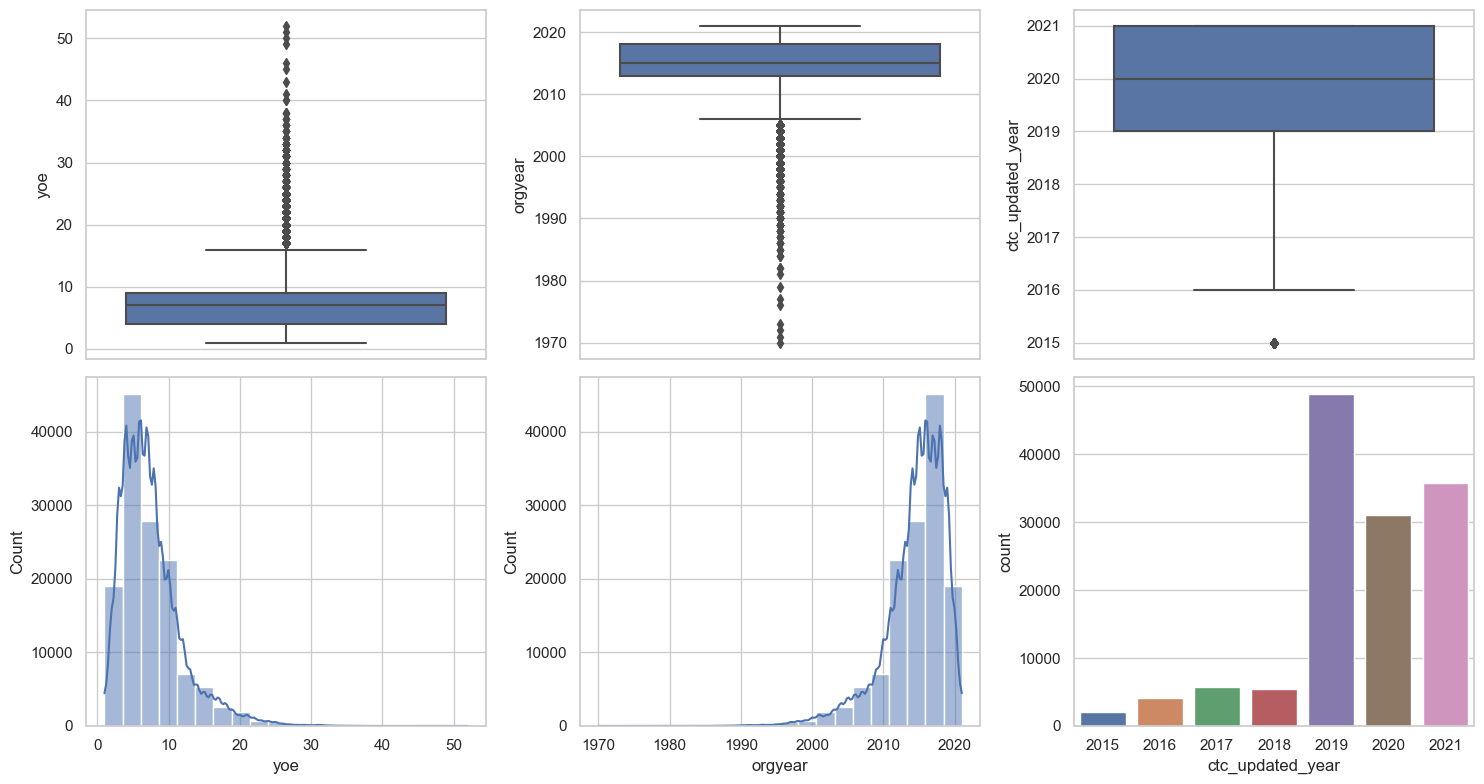

In [57]:
fig, ax = plt.subplots(2,3, figsize=(15, 8))
sns.boxplot(y=df["yoe"], ax=ax[0,0]);
sns.boxplot(y=df["orgyear"], ax=ax[0,1]);
sns.boxplot(y=df["ctc_updated_year"], ax=ax[0,2]);

sns.histplot(data=df.to_pandas(), x="yoe", kde=True, bins=20, ax=ax[1,0]);
sns.histplot(data=df.to_pandas(), x="orgyear",kde=True, bins=20, ax=ax[1,1]);
sns.countplot(data=df.to_pandas() ,x="ctc_updated_year", ax=ax[1,2]);

# plt.suptitle("Boxplot of Years of Experience, Organization Year and CTC Updated Year");
plt.tight_layout();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above plots show distribution of CTC updated year, Years of Experience and joining year
- Most of the candidates have under 10 years of experience.
- Majority of the CTC has been updated from 2019 to 2021.
- Most of the candidates joined after 2010

In [145]:
db.sql(""" 
select distinct job_position, ctc from df where (job_position like '%intern%' or job_position like '%trainee%') order by ctc desc limit 10
""").pl()

shape: (10, 2)
┌────────────────────┬───────────┐
│ job_position       ┆ ctc       │
│ ---                ┆ ---       │
│ str                ┆ i64       │
╞════════════════════╪═══════════╡
│ engineering intern ┆ 200000000 │
│ engineering intern ┆ 155000000 │
│ engineering intern ┆ 100310000 │
│ engineering intern ┆ 100000000 │
│ engineering intern ┆ 80000000  │
│ engineering intern ┆ 20000000  │
│ engineering intern ┆ 19700000  │
│ engineering intern ┆ 14100000  │
│ engineering intern ┆ 12000000  │
│ engineering intern ┆ 11500000  │
└────────────────────┴───────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above table we can see that some job position like intern have extremely high CTC which is not possible.

In [120]:
df["ctc"].quantile(0.95), df["ctc"].quantile(0.05)

(4000000.0, 200000.0)

In [146]:
ctc_filtered_df = df.filter((df["ctc"] < df["ctc"].quantile(0.95)) & (df["ctc"] > df["ctc"].quantile(0.05)))

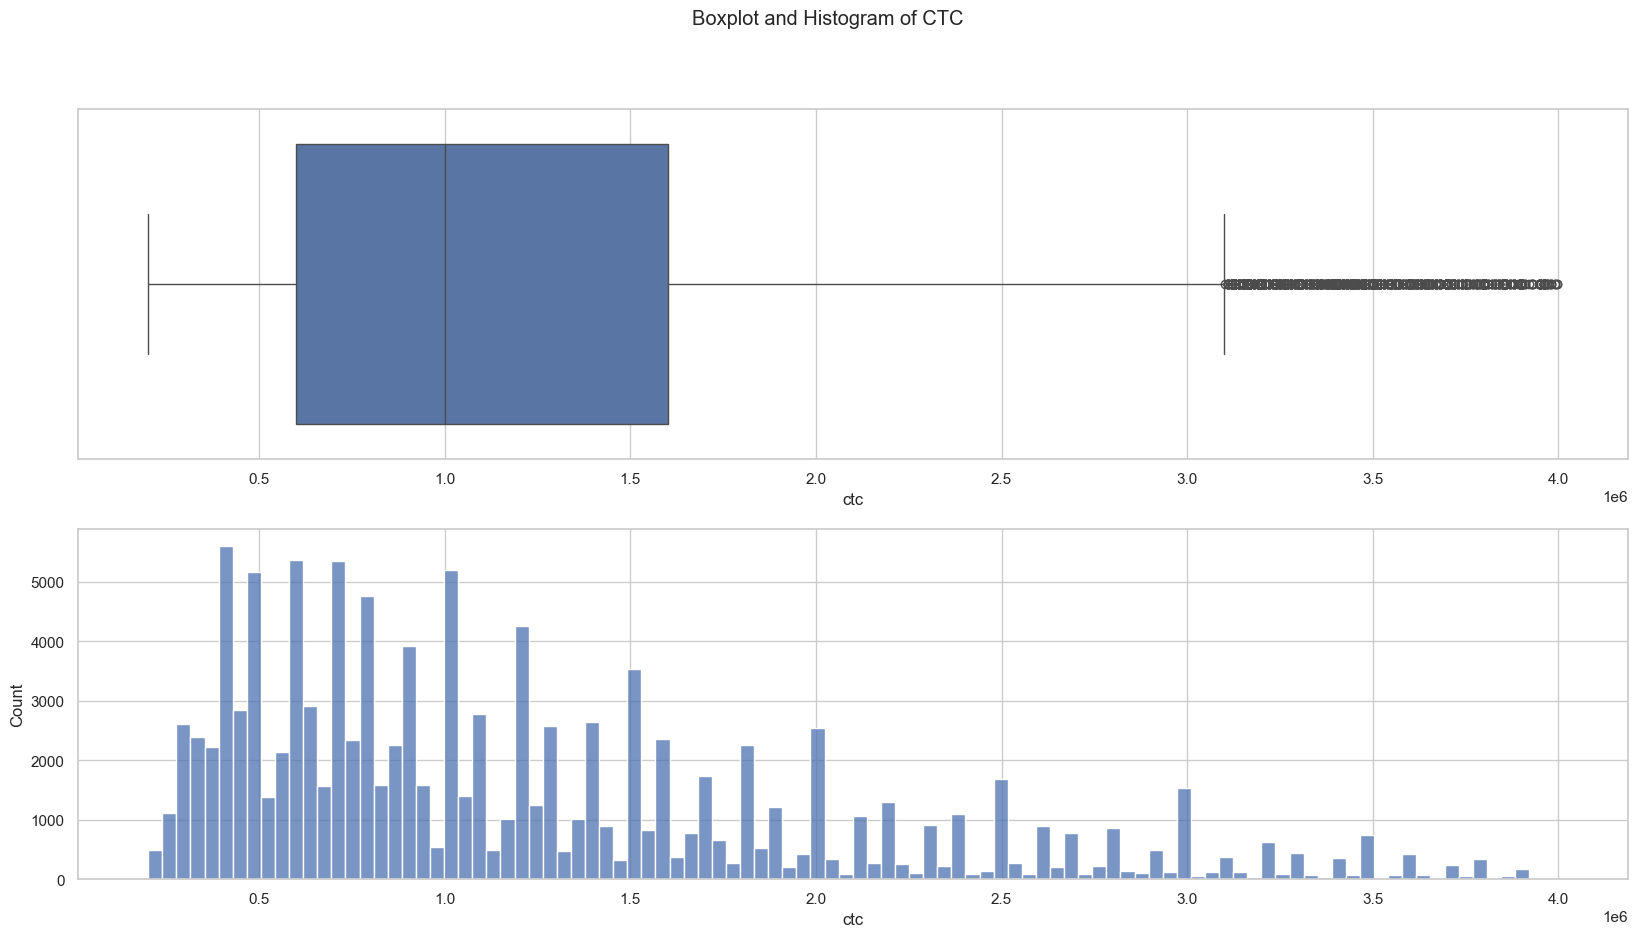

In [147]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
sns.boxplot(x=ctc_filtered_df["ctc"], ax=ax[0]);
sns.histplot(x=ctc_filtered_df["ctc"], ax=ax[1], bins=100);
plt.suptitle("Boxplot and Histogram of CTC");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above table we can see that the most of the CTCs are between 6 to 16 lakhs.

**Mean CTC**

In [148]:
ctc_filtered_df["ctc"].mean(), ctc_filtered_df["ctc"].median()

(1220181.536710552, 1000000.0)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

The mean CTC is around 12 lakhs and median is around 10 lakhs.

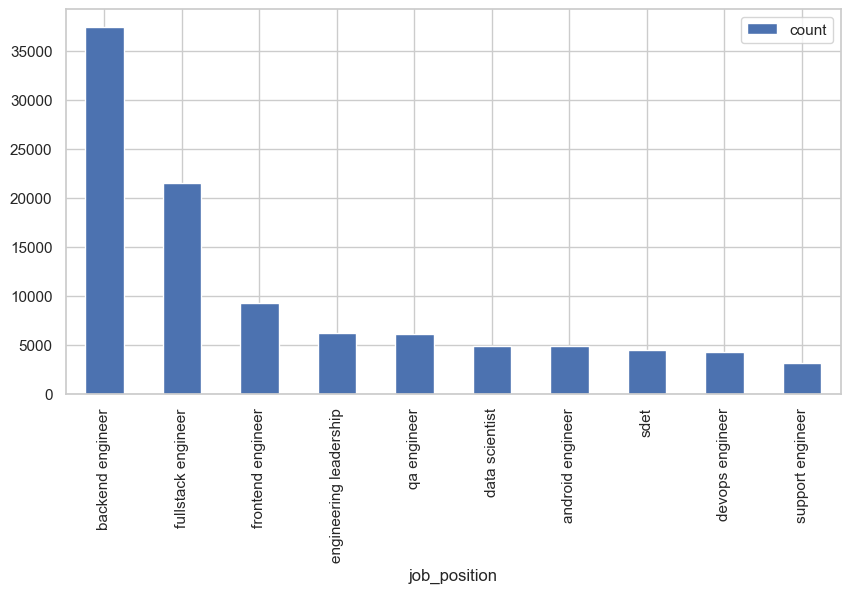

In [87]:
df.filter(df["job_position"]!="other")["job_position"].value_counts(sort=True).head(10).to_pandas().set_index("job_position").plot(kind="bar", figsize=(10, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that most the candidates belong to web developement domain

**Average CTC of top 20 job positions**

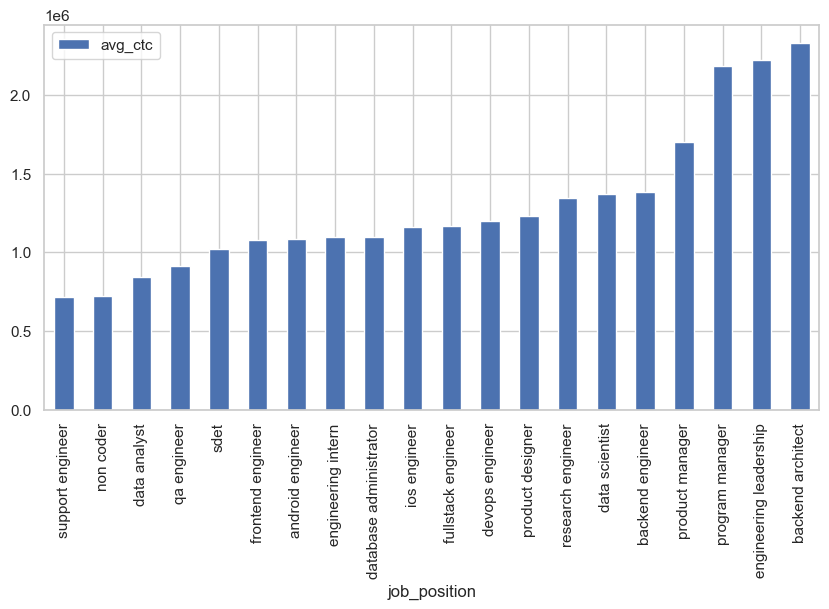

In [68]:
db.sql(""" 
    select job_position, avg(ctc) as avg_ctc from ctc_filtered_df where job_position <> 'other' group by job_position order by count(*) desc limit 20
""").to_df().sort_values(by="avg_ctc").set_index("job_position").plot(kind="bar", figsize=(10, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above is the plot of average ctc for top 20 popular job positions.
- We can see that backend architect has the highest average ctc.

**Check which job position has decreasing CTC with increase in experience**

In [29]:
neg_salary = db.sql(""" 
    WITH salary_diff AS (
        SELECT *,
            LAST(avg_ctc) OVER (PARTITION BY job_position ORDER BY yoe) - 
            AVG(avg_ctc) OVER (PARTITION BY job_position) AS diff
        FROM (
            SELECT job_position, yoe, ROUND(AVG(ctc)) AS avg_ctc, COUNT(*) AS cnt 
            FROM ctc_filtered_df 
            GROUP BY yoe, job_position  
            HAVING cnt > 1
        )
    )
    SELECT job_position, COUNT(*) AS j_cnt 
    FROM salary_diff 
    WHERE diff < 0 
    GROUP BY job_position 
    HAVING j_cnt > 1 
    ORDER BY j_cnt DESC 
""").to_df()

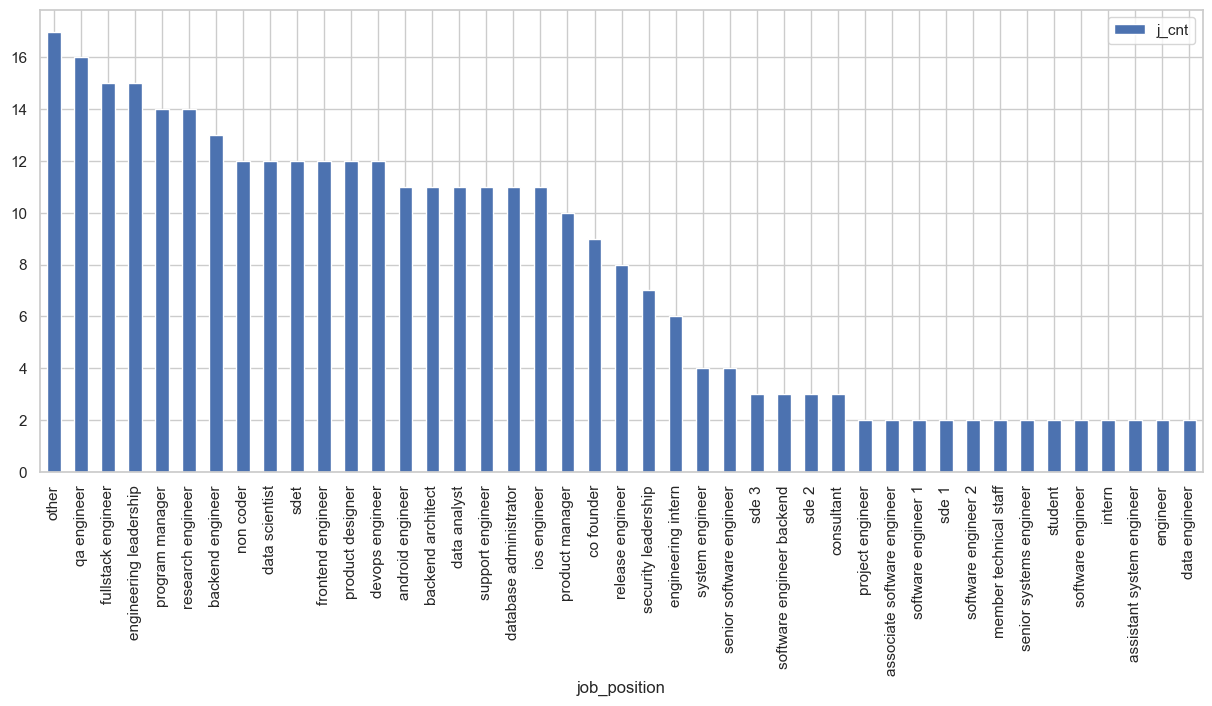

In [31]:
neg_salary.set_index("job_position").plot(kind="bar", figsize=(15, 6));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

From above analysis we can approximately say that QA engineer has decreasing trend in CTC over the years.

In [44]:
# db.sql("""
#     with cte as (
#     select job_position, ctc_updated_year, round(avg(ctc)) avg_ctc, yoe from df group by ctc_updated_year, job_position, yoe having count(*) > 1
#        )
#        select distinct job_position, yoe,
#        first(avg_ctc) over (partition by job_position, yoe order by ctc_updated_year) as first_avg_ctc,
#          last(avg_ctc) over (partition by job_position, yoe order by ctc_updated_year) as last_avg_ct
    
#         from cte where yoe > 1 order by job_position, yoe
# """)

**Comparison of Average CTC of Data Scientist and Other Job Positions**

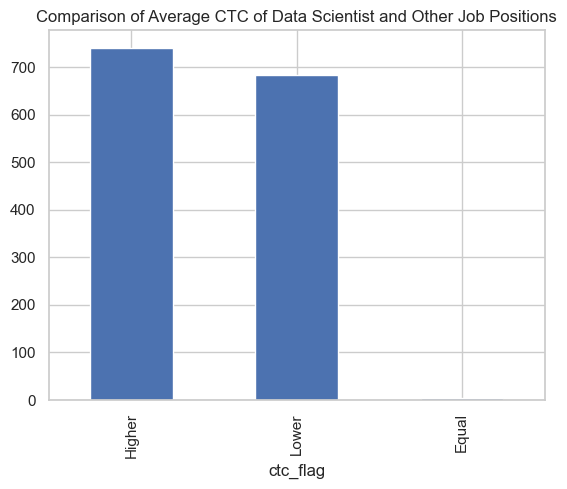

In [176]:
db.sql("""
    WITH ds_ctc AS (
        SELECT 
            company_hash, 
            ROUND(AVG(ctc)) AS avg_ds_ctc 
        FROM df 
        WHERE job_position = 'data scientist' 
        GROUP BY company_hash
    ),
    cte2 AS (
        SELECT 
            DISTINCT df.company_hash, 
            ROUND(AVG(ctc)) AS avg_ctc, 
            avg_ds_ctc 
        FROM df
        JOIN ds_ctc ON df.company_hash = ds_ctc.company_hash
        WHERE job_position <> 'data scientist'
        GROUP BY df.company_hash, avg_ds_ctc
        ORDER BY df.company_hash
    )
    SELECT *, 
        CASE 
            WHEN avg_ctc > avg_ds_ctc THEN 'Higher' 
            WHEN avg_ctc < avg_ds_ctc THEN 'Lower' 
            ELSE 'Equal' 
        END AS ctc_flag
    FROM cte2
""").to_df().value_counts("ctc_flag").plot(kind="bar")

plt.title("Comparison of Average CTC of Data Scientist and Other Job Positions");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

In majority of the cases Data Scientist has higher average CTC than other job positions. But the gap is not that significant.

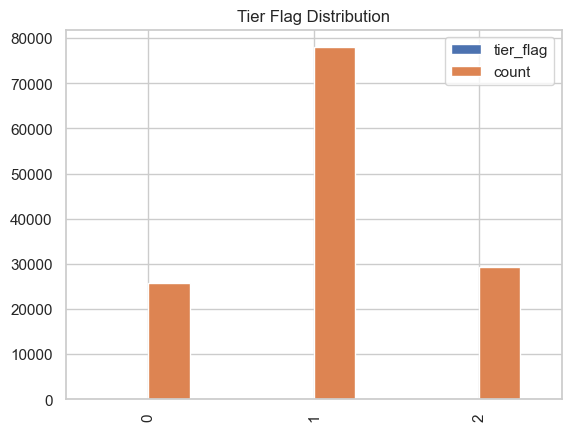

In [180]:
df["tier_flag"].value_counts().to_pandas().plot(kind="bar");
plt.title("Tier Flag Distribution");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Majority of the candidates belong to tier 1 flag, indicating that these candidates have higher than average CTC.

**Top company with highest Tier 1 candidates**

In [187]:
db.sql(""" 
select company_hash, count(*) count from df where tier_flag=1 group by company_hash, tier_flag order by count(*) desc limit 10
""").pl()

shape: (10, 2)
┌─────────────────────────────────┬───────┐
│ company_hash                    ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ i64   │
╞═════════════════════════════════╪═══════╡
│ gqvwrt                          ┆ 532   │
│ vbvkgz                          ┆ 504   │
│ bxwqgogen                       ┆ 397   │
│ uvjnb                           ┆ 249   │
│ vagmt                           ┆ 248   │
│ wxowg                           ┆ 198   │
│ fvrbvqn rvmo                    ┆ 192   │
│ ovbohzs qa xzonxnhnt xzaxv  mv… ┆ 184   │
│ zvsvqqg                         ┆ 181   │
│ xzegojo                         ┆ 180   │
└─────────────────────────────────┴───────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above is the list of top companies with highest tier 1 candidates.

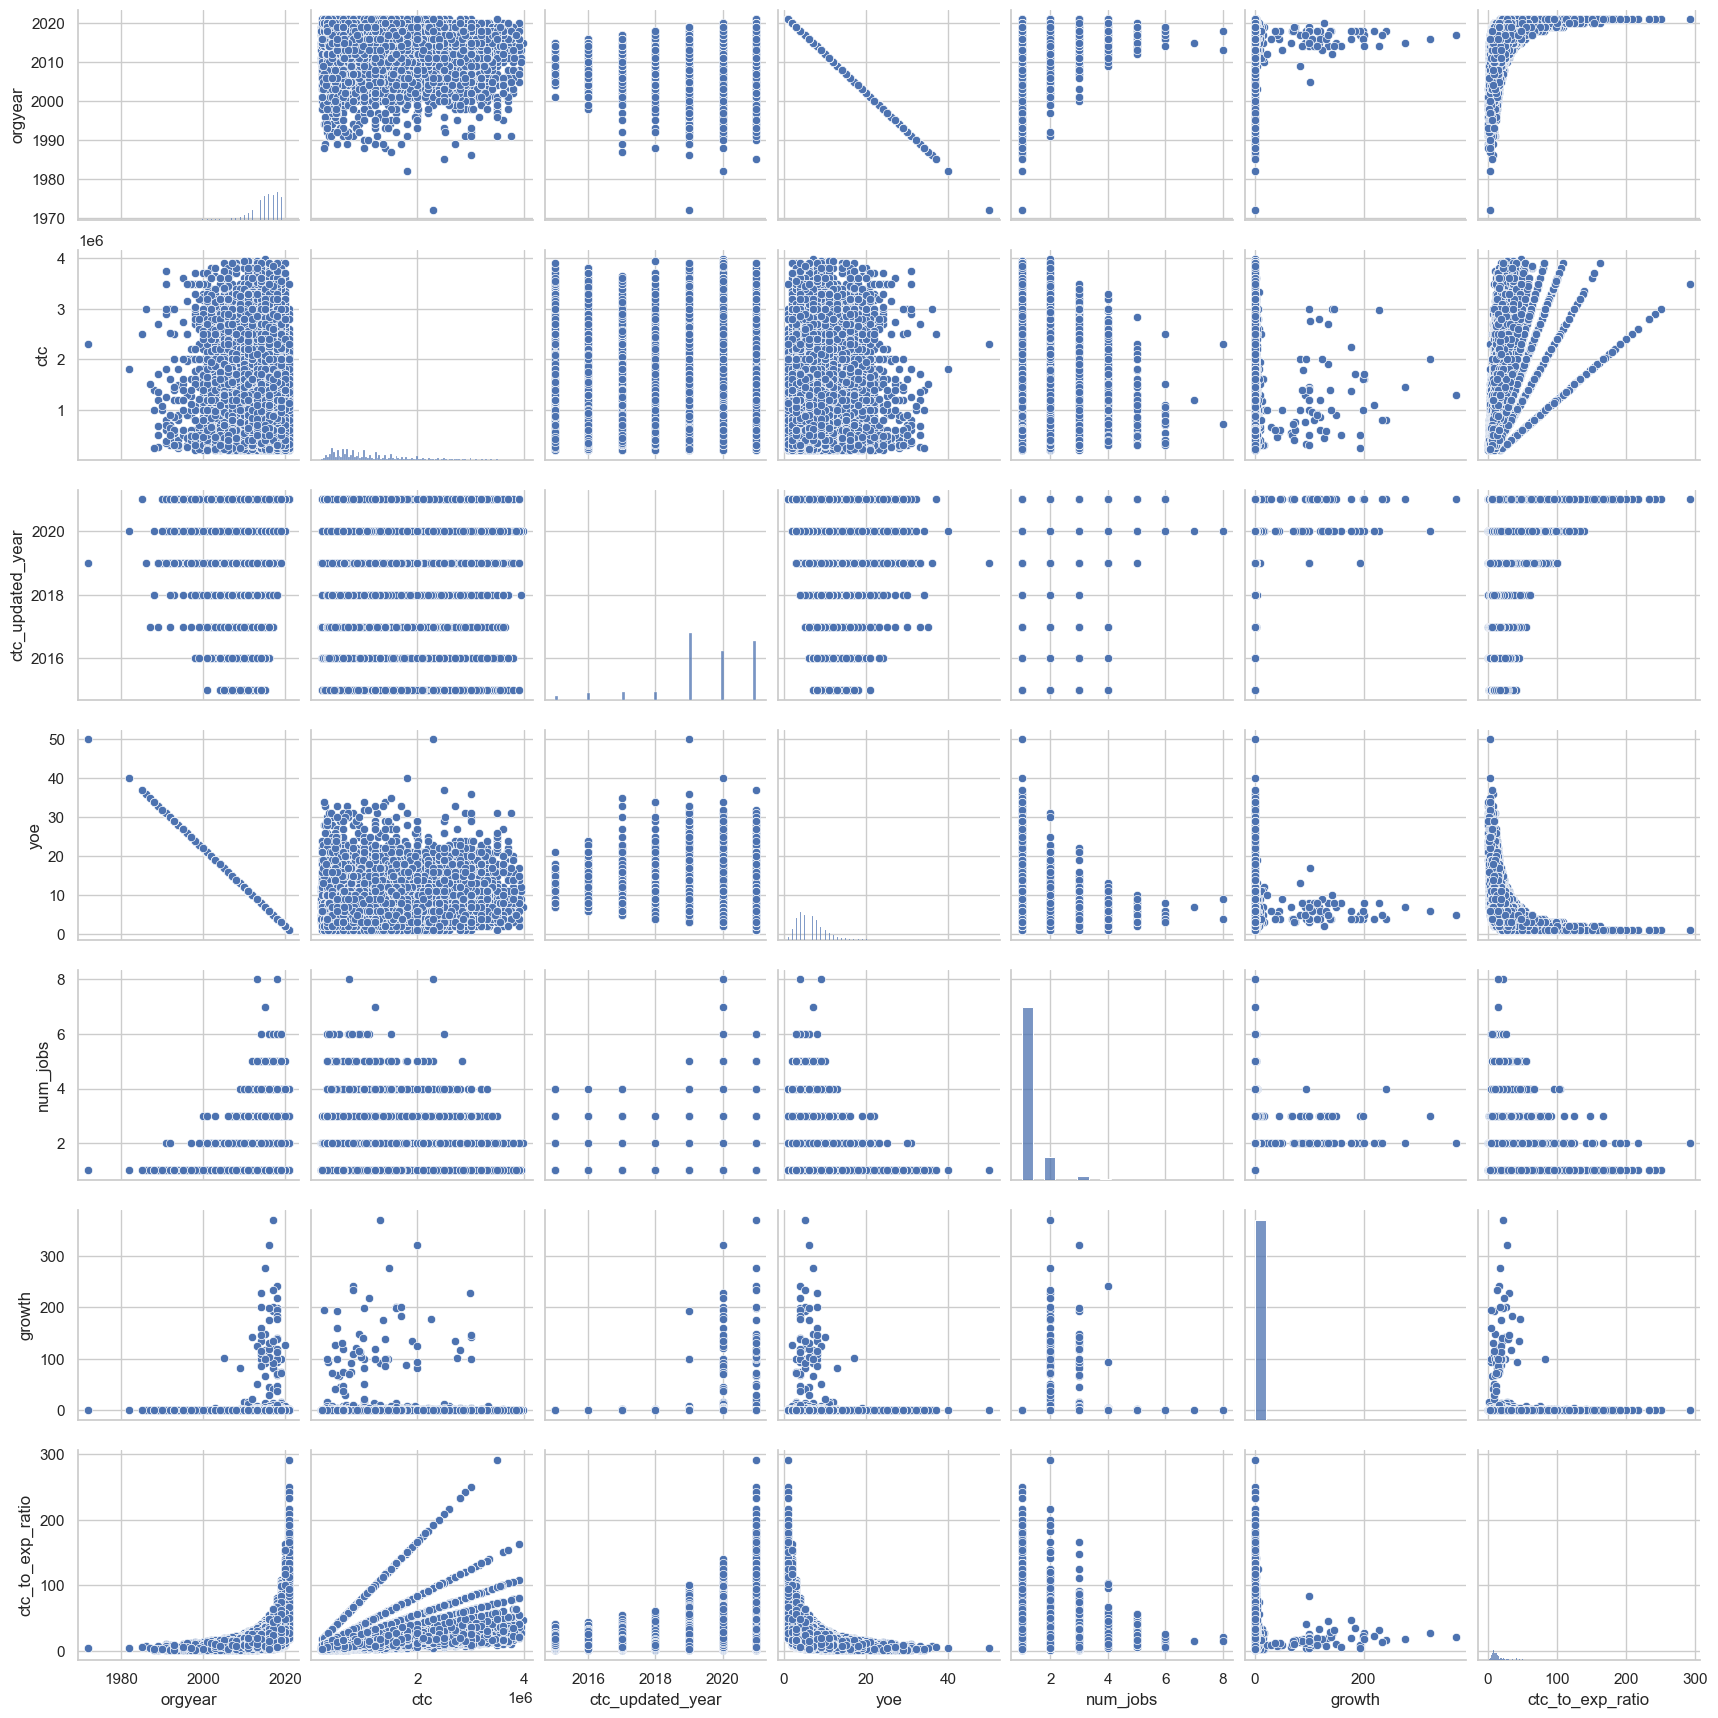

In [203]:
cols=[
 'orgyear',
 'ctc',
 'ctc_updated_year',
 'yoe',
 'num_jobs',
 'growth',
 'ctc_to_exp_ratio',
 ]
sns.pairplot(ctc_filtered_df.filter(ctc_filtered_df["tier_flag"]==3).select(cols).to_pandas());

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that majority of Tier 3 candidates donot switch companies.
- Most of the candidates joined during 2020 but there are employee who have joined before 2000's
- There is huge variance in ctc with respect to experience

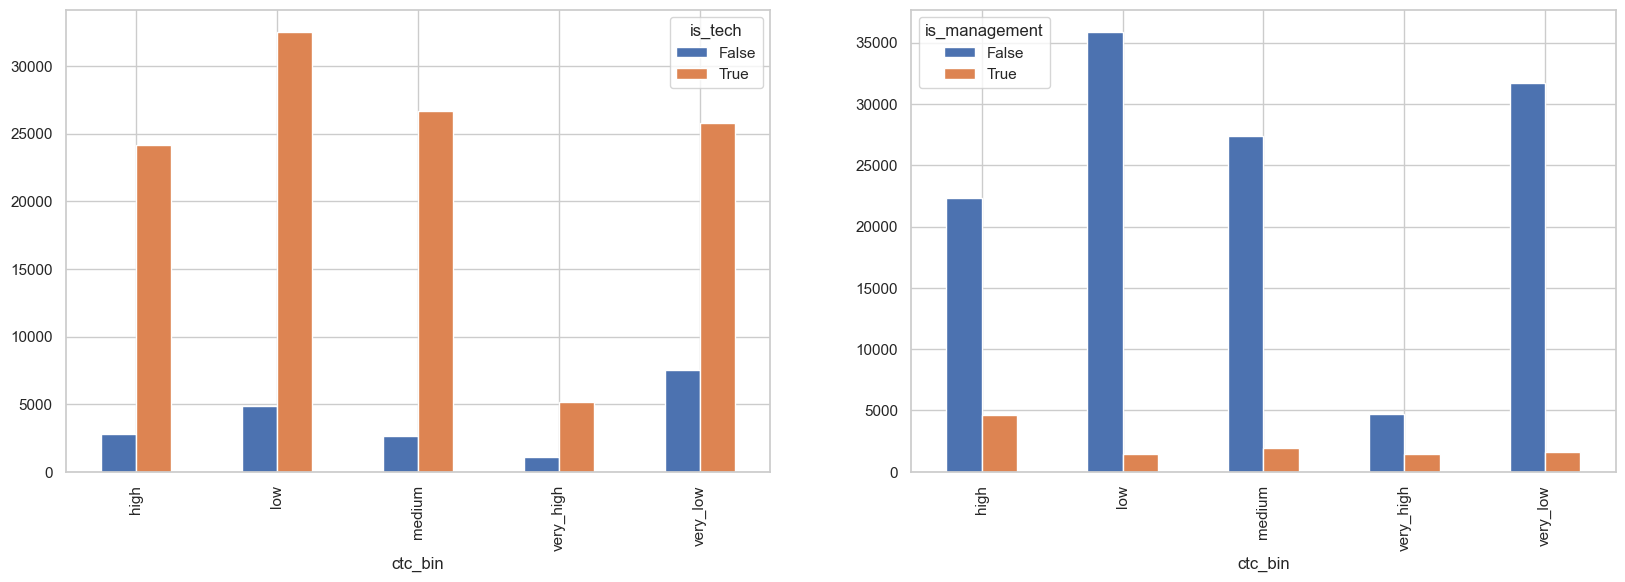

In [182]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))
db.sql("""
    select ctc_bin, is_tech, count(*) as count from df group by ctc_bin, is_tech
""").to_df().pivot(index="ctc_bin", columns="is_tech", values="count").plot(kind="bar", ax=ax[0]);

db.sql("""
    select ctc_bin, is_management, count(*) as count from df group by ctc_bin, is_management
""").to_df().pivot(index="ctc_bin", columns="is_management", values="count").plot(kind="bar", ax=ax[1]);

In [73]:
tech_df = ctc_filtered_df.filter((ctc_filtered_df["is_tech"]) & (ctc_filtered_df["yoe"] < 20))
developer_df = ctc_filtered_df.filter((ctc_filtered_df["is_developer"]) & (ctc_filtered_df["yoe"] < 20))
management_df = ctc_filtered_df.filter((ctc_filtered_df["is_management"]) & (ctc_filtered_df["yoe"] < 40))
sales_df = ctc_filtered_df.filter((ctc_filtered_df["is_sales"]) & (ctc_filtered_df["yoe"] < 20))
non_coder_df = ctc_filtered_df.filter((ctc_filtered_df["is_non_coder"]) & (ctc_filtered_df["yoe"] < 20))

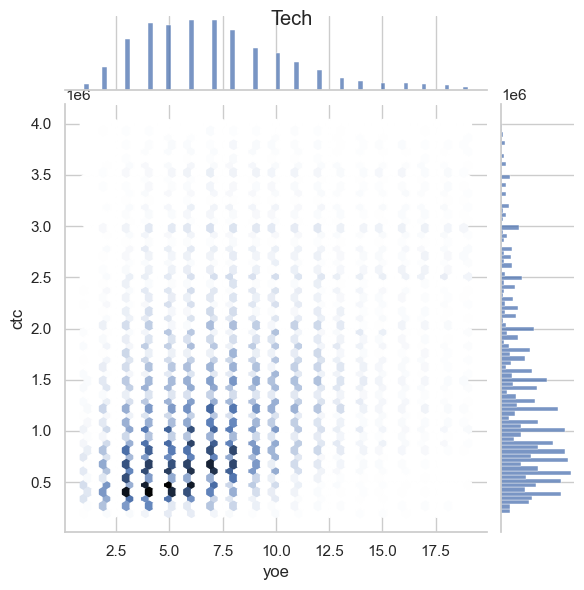

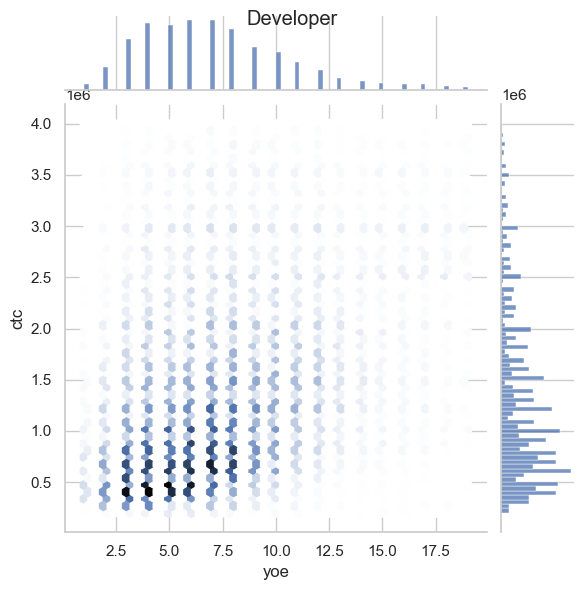

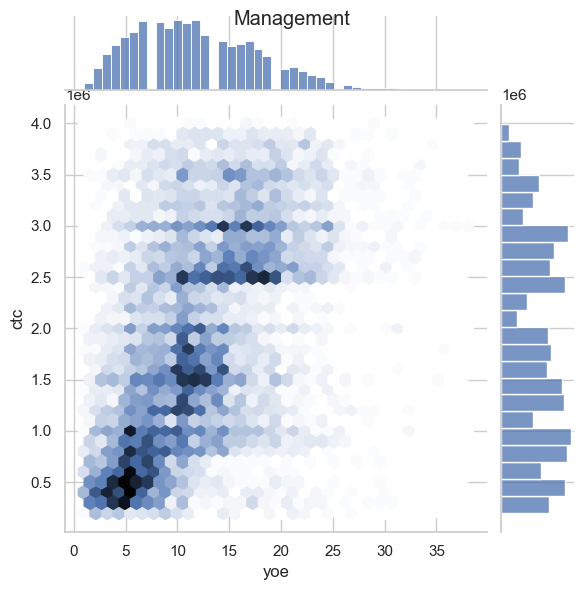

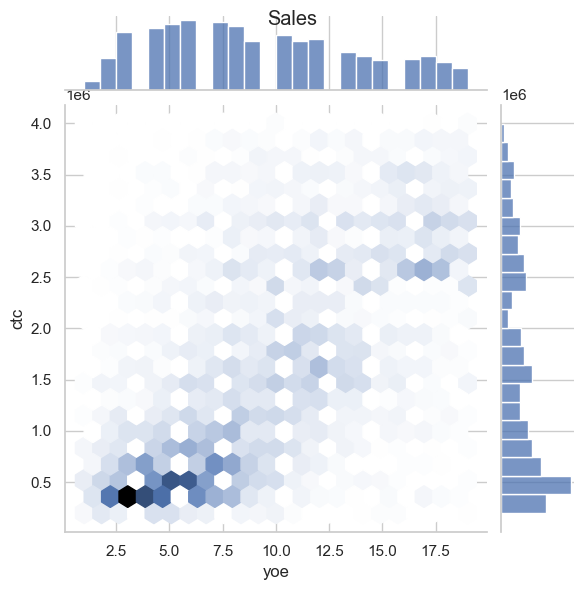

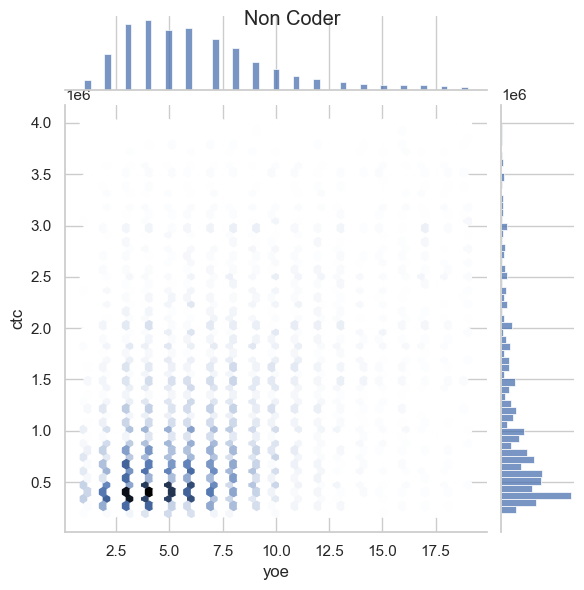

In [74]:
# fig, ax = plt.subplots(2,3, figsize=(20, 10))

sns.jointplot(tech_df["yoe"], tech_df["ctc"], kind="hex");
plt.suptitle("Tech");
sns.jointplot(developer_df["yoe"], developer_df["ctc"], kind="hex");
plt.suptitle("Developer");
sns.jointplot(management_df["yoe"], management_df["ctc"], kind="hex");
plt.suptitle("Management");
sns.jointplot(sales_df["yoe"], sales_df["ctc"], kind="hex");
plt.suptitle("Sales");
sns.jointplot(non_coder_df["yoe"], non_coder_df["ctc"], kind="hex");
plt.suptitle("Non Coder");


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above plots shows the distribution of CTC for different job positions.
- We can also see that sales ctc decreases after 15 years of experience.
- Majority of the sales have less than 5 lakhs CTC.
- Developers have wide range of salary for different experience levels.

# Manual Clustering

In [47]:
df=pl.read_parquet("../data/processed/data.parquet")

**Top 10 employees (earning more than most of the employees in the company) - Tier 1**

In [49]:
df.filter(pl.col("tier_flag") == 1).sort("ctc", descending=True).limit(10)

shape: (10, 20)
┌────────────┬────────────┬───────────┬─────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ company_ha ┆ job_positi ┆ email_has ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin   │
│ sh         ┆ on         ┆ h         ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---       │
│ ---        ┆ ---        ┆ ---       ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str       │
│ str        ┆ str        ┆ str       ┆         ┆   ┆ bool      ┆          ┆ bool      ┆           │
╞════════════╪════════════╪═══════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ qtrxvzwt   ┆ data       ┆ f1b31a501 ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ xzegwgbb   ┆ analyst    ┆ f6b7fd6ed ┆         ┆   ┆           ┆          ┆           ┆           │
│ rxbxnta    ┆            ┆ ae9e7e883 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ bf6…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ otre       ┆ android    ┆ f63e63a8c ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ tburgjta   ┆ engineer   ┆ c3db37c89 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ a49f0498d ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 073…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv sqghu ┆ other      ┆ 3a5fc9df8 ┆ 2013    ┆ … ┆ false     ┆ false    ┆ true      ┆ very_high │
│            ┆            ┆ 19bcc49b5 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 20771ae2f ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ cb9…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ xb  v      ┆ fullstack  ┆ 431c610cf ┆ 2018    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ onhatzn    ┆ engineer   ┆ fb5f69947 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 6173431bb ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 1f4…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ ftrro      ┆ support    ┆ 54bafd5fc ┆ 2015    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_high │
│ evqsg      ┆ engineer   ┆ 688d31915 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 438560bd4 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ e94…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ vrnqvz     ┆ other      ┆ 643caeb3a ┆ 2014    ┆ … ┆ false     ┆ false    ┆ true      ┆ very_high │
│            ┆            ┆ 1b6e1cbba ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 8cb026833 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 609…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvrtza     ┆ support    ┆ 6b3c27564 ┆ 2016    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_high │
│            ┆ engineer   ┆ 3094c663a ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 51e84196f ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ d71…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ otre       ┆ other      ┆ 4f83774df ┆ 2020    ┆ … ┆ false     ┆ false    ┆ true      ┆ very_high │
│ tburgjta   ┆            ┆ e4b97bfd0 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 836463f3a ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 573…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv wgzoh ┆ support    ┆ 199146d59 ┆ 2017    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_high │
│ rnvzwj     ┆ engineer   ┆ 076620fa9 ┆      

**Top 10 employees of data science in each company earning more than their peers - Class 1**

In [51]:
db.sql("""
select * from df where job_position like 'data %' and class_flag = 1 order by ctc desc limit 10
""").pl()

shape: (10, 20)
┌────────────┬────────────┬───────────┬─────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ company_ha ┆ job_positi ┆ email_has ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin   │
│ sh         ┆ on         ┆ h         ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---       │
│ ---        ┆ ---        ┆ ---       ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str       │
│ str        ┆ str        ┆ str       ┆         ┆   ┆ bool      ┆          ┆ bool      ┆           │
╞════════════╪════════════╪═══════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ zgzt       ┆ data       ┆ 268a5aa92 ┆ 2019    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ scientist  ┆ f0b6d0c67 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 5fc9cc1e3 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 00e…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv wgzoh ┆ data       ┆ 655da5cd9 ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ rnvzwj     ┆ analyst    ┆ 9f1ba4ad2 ┆         ┆   ┆           ┆          ┆           ┆           │
│ otqcxwto   ┆            ┆ 49dade503 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 9b9…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ wgzahtzn   ┆ data       ┆ 9ce2995b2 ┆ 2016    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 221fe627e ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 861daea9d ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 060…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv wgzoh ┆ data       ┆ 59316048d ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ rnvzwj     ┆ analyst    ┆ 113539202 ┆         ┆   ┆           ┆          ┆           ┆           │
│ otqcxwto   ┆            ┆ 325e05af9 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ b66…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ vwwtznhqt  ┆ data       ┆ 2f9a42410 ┆ 2016    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 53f76b2f8 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ c50ea593a ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 905…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ wgszxkvzn  ┆ data       ┆ aad581a53 ┆ 2014    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 2f319c76c ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 6e7393757 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 2fe…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ gnytq      ┆ data       ┆ 6d4a5d19e ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 889596252 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ b038ee040 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 951…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ ntwy       ┆ data       ┆ 7a723f5b7 ┆ 2019    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ bvyxzaqv   ┆ analyst    ┆ 1698674b7 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 9bd2195c3 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ bb5…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ fxuqg      ┆ data       ┆ 89f343bf0 ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ rxbxnta    ┆ analyst    ┆ 1094accb8 ┆      

**Bottom 10 employees of data science in each company earning less than their peers - Class 3**

In [52]:
db.sql("""
select * from df where job_position like 'data %' and class_flag = 3 order by ctc asc limit 10
""").pl()

shape: (10, 20)
┌────────────┬────────────┬────────────┬─────────┬───┬───────────┬──────────┬───────────┬──────────┐
│ company_ha ┆ job_positi ┆ email_hash ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin  │
│ sh         ┆ on         ┆ ---        ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---      │
│ ---        ┆ ---        ┆ str        ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str      │
│ str        ┆ str        ┆            ┆         ┆   ┆ bool      ┆          ┆ bool      ┆          │
╞════════════╪════════════╪════════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪══════════╡
│ wgszxkvzn  ┆ data       ┆ abf69e786d ┆ 2014    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ analyst    ┆ aa23f50d31 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 42b653235e ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ nvnv wgzoh ┆ data       ┆ 00cd570173 ┆ 2012    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ rnvzwj     ┆ analyst    ┆ 17c2beea73 ┆         ┆   ┆           ┆          ┆           ┆          │
│ otqcxwto   ┆            ┆ de68b4835d ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ nvnv wgzoh ┆ data       ┆ 3175d03fd4 ┆ 2020    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ rnvzwj     ┆ scientist  ┆ 618eb293d6 ┆         ┆   ┆           ┆          ┆           ┆          │
│ otqcxwto   ┆            ┆ f5a1d13d42 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ vqxosrgmvr ┆ data       ┆ 3675f79c7e ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ scientist  ┆ 05de96ccf1 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 89c818b84b ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ sggsrt     ┆ data       ┆ fb64af6154 ┆ 2018    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ scientist  ┆ 20e06d46a1 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 965f59068b ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ ytfrtnn    ┆ data       ┆ 8274b31884 ┆ 2018    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ uvwpvqa    ┆ scientist  ┆ 70cd1c4914 ┆         ┆   ┆           ┆          ┆           ┆          │
│ tzntquqxot ┆            ┆ e7face4901 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ ahzzyhbmj  ┆ data       ┆ d32c344816 ┆ 2016    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ scientist  ┆ 921ae7be31 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 0ba7630c6e ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ zvz        ┆ data       ┆ d277c90e2b ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ scientist  ┆ 97fb516579 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 36b66b68ee ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ tqxwoogz   ┆ data       ┆ d8b6c25488 ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ scientist  ┆ ee764c6dbd ┆     

**Bottom 10 employees (earning less than most of the employees in the company)- Tier 3**

In [53]:
df.filter(pl.col("tier_flag") == 3).sort("ctc", descending=False).limit(10)

shape: (10, 20)
┌────────────┬────────────┬────────────┬─────────┬───┬───────────┬──────────┬───────────┬──────────┐
│ company_ha ┆ job_positi ┆ email_hash ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin  │
│ sh         ┆ on         ┆ ---        ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---      │
│ ---        ┆ ---        ┆ str        ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str      │
│ str        ┆ str        ┆            ┆         ┆   ┆ bool      ┆          ┆ bool      ┆          │
╞════════════╪════════════╪════════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪══════════╡
│ gjg        ┆ fullstack  ┆ b995d7a2ae ┆ 2018    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ engineer   ┆ 5c6f849776 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 2ce04dc5c0 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ nvnv wgzoh ┆ backend    ┆ 80ba0259f9 ┆ 2012    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ rnvzwj     ┆ engineer   ┆ f59034c492 ┆         ┆   ┆           ┆          ┆           ┆          │
│ otqcxwto   ┆            ┆ 7cf3bd38dc ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ tznqtuqtzt ┆ fullstack  ┆ 5281828ed6 ┆ 2001    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ hq btaxv   ┆ engineer   ┆ 0da057750f ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ ca673995fe ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ bgqsvz     ┆ backend    ┆ 78eaccdfac ┆ 2011    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ onvzrtj    ┆ engineer   ┆ f1b3d73037 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ a6e86451d6 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ evwtmggp   ┆ fullstack  ┆ e59b4841a8 ┆ 2013    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│            ┆ engineer   ┆ 316f580908 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 39eba1787d ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ sgrabvz    ┆ engineerin ┆ aaca628b0b ┆ 2018    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ ovwyo      ┆ g intern   ┆ 240afc71c3 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 4e7d592243 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ onhatzn    ┆ engineerin ┆ 56fba328d9 ┆ 2016    ┆ … ┆ true      ┆ true     ┆ false     ┆ very_low │
│            ┆ g          ┆ e0187923d9 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆ leadership ┆ 2f680369ae ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ gnytqo     ┆ other      ┆ f8574b6721 ┆ 2018    ┆ … ┆ false     ┆ false    ┆ true      ┆ very_low │
│            ┆            ┆ 12433b60b8 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ ca5178ccd9 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ sggsrt     ┆ co founder ┆ 5756870d89 ┆ 1973    ┆ … ┆ true      ┆ true     ┆ true      ┆ very_low │
│            ┆            ┆ 5deca92025 ┆     

**Top 10 employees in each company - X department - having 5/6/7 years of experience earning more than their peers - Tier X**

In [63]:
db.sql(""" 
    WITH cte AS (
        SELECT *, 
            ROW_NUMBER() OVER (PARTITION BY company_hash ORDER BY ctc DESC) AS rn
        FROM df 
        WHERE tier_flag = 1 AND designation_flag = 1 AND yoe BETWEEN 5 AND 7
    ) 
    SELECT * 
    FROM cte 
    WHERE rn <= 10 
    ORDER BY company_hash, job_position, ctc DESC
""").pl()

shape: (3_988, 21)
┌─────────────┬─────────────┬─────────────┬─────────┬───┬──────────┬─────────────┬───────────┬─────┐
│ company_has ┆ job_positio ┆ email_hash  ┆ orgyear ┆ … ┆ is_sales ┆ is_non_code ┆ ctc_bin   ┆ rn  │
│ h           ┆ n           ┆ ---         ┆ ---     ┆   ┆ ---      ┆ r           ┆ ---       ┆ --- │
│ ---         ┆ ---         ┆ str         ┆ i32     ┆   ┆ bool     ┆ ---         ┆ str       ┆ i64 │
│ str         ┆ str         ┆             ┆         ┆   ┆          ┆ bool        ┆           ┆     │
╞═════════════╪═════════════╪═════════════╪═════════╪═══╪══════════╪═════════════╪═══════════╪═════╡
│ 1bs         ┆ backend     ┆ 31db7b806a8 ┆ 2016    ┆ … ┆ false    ┆ false       ┆ high      ┆ 1   │
│             ┆ engineer    ┆ 2aac024462d ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ 4c97e70e…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ 1bs         ┆ backend     ┆ 579d9c719cc ┆ 2015    ┆ … ┆ false    ┆ false       ┆ high      ┆ 2   │
│             ┆ engineer    ┆ 05b88529725 ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ 6c122585…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ 1bs         ┆ backend     ┆ 9c02076a74a ┆ 2016    ┆ … ┆ false    ┆ false       ┆ high      ┆ 3   │
│             ┆ engineer    ┆ 2b8a64a6e00 ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ 3fa0a2e4…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ 1bs         ┆ backend     ┆ 38dfe791fc9 ┆ 2015    ┆ … ┆ false    ┆ false       ┆ high      ┆ 4   │
│             ┆ engineer    ┆ 11da418b67a ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ a989a6aa…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ 1bs         ┆ backend     ┆ c97fd161208 ┆ 2015    ┆ … ┆ false    ┆ false       ┆ high      ┆ 5   │
│             ┆ engineer    ┆ 0086b898e44 ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ 0529c863…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ …           ┆ …           ┆ …           ┆ …       ┆ … ┆ …        ┆ …           ┆ …         ┆ …   │
│ zxzlvwvqn   ┆ backend     ┆ 1ec1cf024ba ┆ 2017    ┆ … ┆ false    ┆ false       ┆ high      ┆ 6   │
│             ┆ engineer    ┆ 4147f65cda8 ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ 324ca5f4…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ zxzlvwvqn   ┆ backend     ┆ 486122d99d9 ┆ 2015    ┆ … ┆ false    ┆ false       ┆ high      ┆ 7   │
│             ┆ engineer    ┆ df25e478a87 ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ ff7d21cb…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ zxzlvwvqn   ┆ fullstack   ┆ e2377e7ee0d ┆ 2017    ┆ … ┆ false    ┆ false       ┆ high      ┆ 5   │
│             ┆ engineer    ┆ 53d2e3a45b9 ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ 687fdc9c…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ zxztrtvuo   ┆ backend     ┆ 303aab779b6 ┆ 2015    ┆ … ┆ false    ┆ false       ┆ very_high ┆ 1   │
│             ┆ engineer    ┆ daea19317b4 ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ 30f600b0…   ┆         ┆   ┆          ┆             ┆           ┆     │
│ zxztrtvuo   ┆ fullstack   ┆ 3879b9a1e35 ┆ 2017    ┆ … ┆ false    ┆ false       ┆ medium    ┆ 2   │
│             ┆ engineer    ┆ 6ed20363fff ┆         ┆   ┆          ┆             ┆           ┆     │
│             ┆             ┆ d6871207…   ┆         ┆   ┆          ┆             ┆           ┆     │
└─────────────┴─────────────┴─────────────┴─────────┴───┴──────────┴─────────────┴───────────┴─────┘

  **Top 10 companies (based on their CTC)**

In [65]:
db.sql("""
    select company_hash, avg(ctc) as avg_ctc from df group by company_hash order by avg_ctc desc limit 10
""").pl()

shape: (10, 2)
┌─────────────────────────────────┬─────────┐
│ company_hash                    ┆ avg_ctc │
│ ---                             ┆ ---     │
│ str                             ┆ f64     │
╞═════════════════════════════════╪═════════╡
│ ztnowqxmto                      ┆ 2e8     │
│ nco rgsxonxwo otqcxwto rxbxnta  ┆ 2e8     │
│ neny                            ┆ 2e8     │
│ rvmayx rxetonjrt rxbxnta        ┆ 2e8     │
│ bjnqvy tztqsj xzaxv ucn rna     ┆ 2e8     │
│ exatrxo wgqugqvnt ogrhnxgzo     ┆ 2e8     │
│ xzntrrxstzwt bvzugftq otqcxwto… ┆ 2e8     │
│ ztnwrgha ojontbo uqxcvnt rxbxn… ┆ 2e8     │
│ pyxcqvl vhngbgmxrto             ┆ 2e8     │
│ xwhmt ogrhnxgzo                 ┆ 2e8     │
└─────────────────────────────────┴─────────┘

  **Top 2 positions in every company (based on their CTC)**

In [86]:
db.sql("""
    WITH cte AS (
        SELECT *, 
            ROW_NUMBER() OVER (PARTITION BY company_hash ORDER BY ctc DESC) AS rn
        FROM df 
    )
    select company_hash, job_position, ctc from cte where rn <=2 order by company_hash desc, ctc desc
""").pl()

shape: (41_443, 3)
┌────────────────────────────────┬────────────────────┬─────────┐
│ company_hash                   ┆ job_position       ┆ ctc     │
│ ---                            ┆ ---                ┆ ---     │
│ str                            ┆ str                ┆ i64     │
╞════════════════════════════════╪════════════════════╪═════════╡
│ zzb ztdnstz vacxogqj ucn rna   ┆ fullstack engineer ┆ 600000  │
│ zz                             ┆ other              ┆ 1370000 │
│ zyvzwt wgzohrnxzs tzsxzttqo    ┆ frontend engineer  ┆ 940000  │
│ zyuw rxbxnta                   ┆ frontend engineer  ┆ 2400000 │
│ zyco xzaxv                     ┆ other              ┆ 600000  │
│ …                              ┆ …                  ┆ …       │
│ 05mz exzytvrny uqxcvnt rxbxnta ┆ backend engineer   ┆ 1100000 │
│ 01 ojztqsj                     ┆ frontend engineer  ┆ 830000  │
│ 01 ojztqsj                     ┆ android engineer   ┆ 270000  │
│ 0000                           ┆ other              ┆ 300000  │
│ 0                              ┆ other              ┆ 100000  │
└────────────────────────────────┴────────────────────┴─────────┘

## Plotting Manual Clusters

In [46]:
df=df.drop(["email_hash","is_tech"])
df = df.with_columns(
    ctc_bin=pl.when(pl.col("ctc_bin") == "very_high").then(5)
    .when(pl.col("ctc_bin") == "high").then(4)
    .when(pl.col("ctc_bin") == "medium").then(3)
    .when(pl.col("ctc_bin") == "low").then(2)
    .otherwise(1)
)
job_frequency_df = df.group_by("job_position").agg(pl.count().alias("job_pos_frequency"))
df = df.join(job_frequency_df, on="job_position", how="left")
df=df.drop(["job_position"])
df=df.rename({"job_pos_frequency": "job_position"})
company_frequency_df = df.group_by("company_hash").agg(pl.count().alias("company_frequency"))
df = df.join(company_frequency_df, on="company_hash", how="left")
df=df.drop(["company_hash"])
df=df.rename({"company_frequency": "company_hash"})

In [80]:
df = df.with_columns(
    ctc=(df["ctc"] - df["ctc"].mean()) / df["ctc"].std(),
    yoe=(df["yoe"] - df["yoe"].mean()) / df["yoe"].std(),
    orgyear=(df["orgyear"] - df["orgyear"].mean()) / df["orgyear"].std(),
    ctc_updated_year=(df["ctc_updated_year"] - df["ctc_updated_year"].mean()) / df["ctc_updated_year"].std(),
    job_position=(df["job_position"] - df["job_position"].mean()) / df["job_position"].std(),
    ctc_bin=(df["ctc_bin"] - df["ctc_bin"].mean()) / df["ctc_bin"].std(),
    ctc_to_exp_ratio=(df["ctc_to_exp_ratio"] - df["ctc_to_exp_ratio"].mean()) / df["ctc_to_exp_ratio"].std(),
    growth=(df["growth"] - df["growth"].mean()) / df["growth"].std(),
    num_jobs=(df["num_jobs"] - df["num_jobs"].mean()) / df["num_jobs"].std(),
    company_hash=(df["company_hash"] - df["company_hash"].mean()) / df["company_hash"].std(),
)

df = df.with_columns(
    is_other=pl.col("is_other").cast(pl.Int32),
    is_developer=pl.col("is_developer").cast(pl.Int32),
    is_management=pl.col("is_management").cast(pl.Int32),
    is_non_coder=pl.col("is_non_coder").cast(pl.Int32),
    is_sales=pl.col("is_sales").cast(pl.Int32),
)

In [85]:
df = df.unique()
df

shape: (119_771, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ orgyear   ┆ ctc       ┆ ctc_updat ┆ yoe       ┆ … ┆ is_non_co ┆ ctc_bin   ┆ job_posit ┆ company_ │
│ ---       ┆ ---       ┆ ed_year   ┆ ---       ┆   ┆ der       ┆ ---       ┆ ion       ┆ hash     │
│ f64       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆           ┆   ┆ i32       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.27299   ┆ -0.069908 ┆ 0.3798    ┆ -1.27299  ┆ … ┆ 0         ┆ 0.40634   ┆ -0.632186 ┆ 0.315777 │
│ 0.808337  ┆ -0.149511 ┆ -0.363565 ┆ -0.808337 ┆ … ┆ 0         ┆ -0.428769 ┆ -1.120752 ┆ -0.44777 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ 0.57601   ┆ -0.161451 ┆ -0.363565 ┆ -0.57601  ┆ … ┆ 0         ┆ -1.263878 ┆ 0.262518  ┆ 4.088932 │
│ -1.050274 ┆ -0.149511 ┆ -0.363565 ┆ 1.050274  ┆ … ┆ 0         ┆ -0.428769 ┆ -0.853597 ┆ -0.49025 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 4        │
│ 0.111358  ┆ -0.139958 ┆ -0.363565 ┆ -0.111358 ┆ … ┆ 0         ┆ -0.428769 ┆ -0.862877 ┆ -0.46795 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 0.57601   ┆ -0.14155  ┆ 1.123165  ┆ -0.57601  ┆ … ┆ 0         ┆ -0.428769 ┆ 1.420651  ┆ -0.45520 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ -1.2826   ┆ -0.081849 ┆ -0.363565 ┆ 1.2826    ┆ … ┆ 0         ┆ 0.40634   ┆ -1.215966 ┆ -0.47113 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ -0.120969 ┆ -0.149511 ┆ 1.123165  ┆ 0.120969  ┆ … ┆ 1         ┆ -0.428769 ┆ -0.1643   ┆ -0.48069 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ -4.53517  ┆ 0.184819  ┆ -0.363565 ┆ 4.53517   ┆ … ┆ 0         ┆ 2.076557  ┆ -0.853597 ┆ -0.20564 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 7        │
│ 0.111358  ┆ -0.085829 ┆ -0.363565 ┆ -0.111358 ┆ … ┆ 0         ┆ 0.40634   ┆ 1.420651  ┆ -0.48813 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [86]:
X=df.to_pandas()

In [89]:
X_embedded_pca = PCA(n_components=2).fit_transform(X.drop(["class_flag","designation_flag","tier_flag"], axis=1))

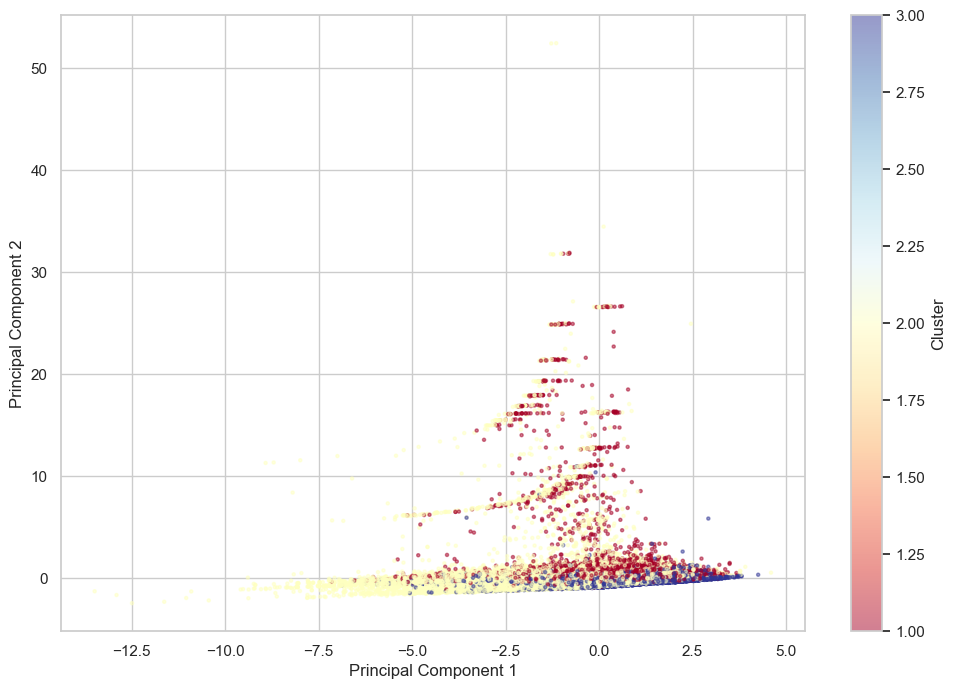

In [90]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=X["class_flag"]  , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

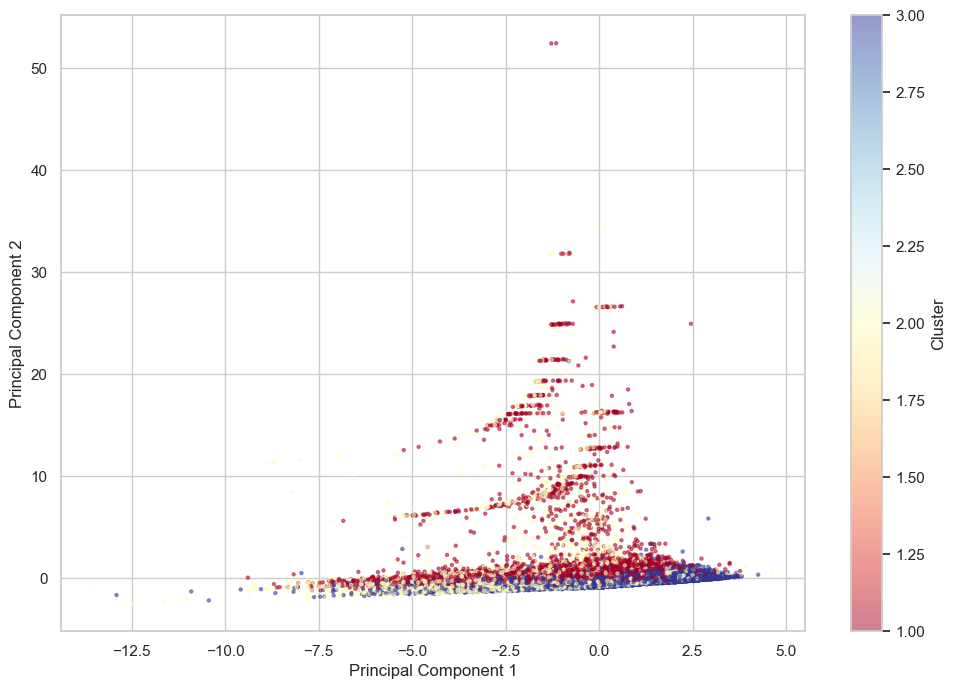

In [91]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=X["designation_flag"]  , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

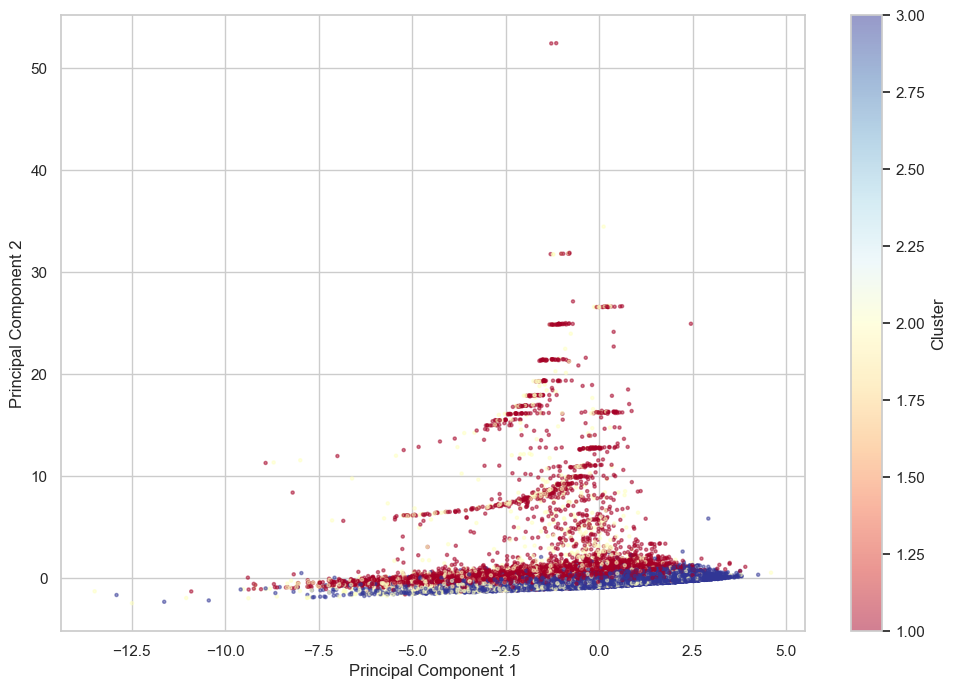

In [92]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=X["tier_flag"]  , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

# Standardization & Encoding

In [87]:
df=pl.read_parquet("../data/processed/data.parquet")

In [88]:
df=df.drop(["email_hash", "class_flag", "designation_flag", "tier_flag","company_hash", "is_tech"])

In [89]:
df

shape: (133_146, 14)
┌─────────────┬─────────┬─────────┬────────────┬───┬────────────┬──────────┬────────────┬──────────┐
│ job_positio ┆ orgyear ┆ ctc     ┆ ctc_update ┆ … ┆ is_managem ┆ is_sales ┆ is_non_cod ┆ ctc_bin  │
│ n           ┆ ---     ┆ ---     ┆ d_year     ┆   ┆ ent        ┆ ---      ┆ er         ┆ ---      │
│ ---         ┆ i32     ┆ i64     ┆ ---        ┆   ┆ ---        ┆ bool     ┆ ---        ┆ str      │
│ str         ┆         ┆         ┆ i32        ┆   ┆ bool       ┆          ┆ bool       ┆          │
╞═════════════╪═════════╪═════════╪════════════╪═══╪════════════╪══════════╪════════════╪══════════╡
│ data        ┆ 2014    ┆ 950000  ┆ 2021       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ analyst     ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ backend     ┆ 2015    ┆ 420000  ┆ 2016       ┆ … ┆ false      ┆ false    ┆ false      ┆ very_low │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ data        ┆ 2017    ┆ 1800000 ┆ 2019       ┆ … ┆ false      ┆ false    ┆ false      ┆ high     │
│ scientist   ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ fullstack   ┆ 2017    ┆ 700000  ┆ 2021       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ backend     ┆ 2013    ┆ 1000000 ┆ 2016       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ …           ┆ …       ┆ …       ┆ …          ┆ … ┆ …          ┆ …        ┆ …          ┆ …        │
│ sdet        ┆ 2014    ┆ 600000  ┆ 2019       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ support     ┆ 2016    ┆ 220000  ┆ 2019       ┆ … ┆ false      ┆ true     ┆ false      ┆ very_low │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ other       ┆ 2005    ┆ 2500000 ┆ 2021       ┆ … ┆ false      ┆ false    ┆ true       ┆ high     │
│ android     ┆ 2019    ┆ 1050000 ┆ 2020       ┆ … ┆ false      ┆ false    ┆ false      ┆ medium   │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ android     ┆ 2019    ┆ 1200000 ┆ 2021       ┆ … ┆ false      ┆ false    ┆ false      ┆ medium   │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
└─────────────┴─────────┴─────────┴────────────┴───┴────────────┴──────────┴────────────┴──────────┘

In [90]:
df = df.with_columns(
    ctc_bin=pl.when(pl.col("ctc_bin") == "very_high").then(5)
    .when(pl.col("ctc_bin") == "high").then(4)
    .when(pl.col("ctc_bin") == "medium").then(3)
    .when(pl.col("ctc_bin") == "low").then(2)
    .otherwise(1)
)

In [91]:
job_frequency_df = df.group_by("job_position").agg(pl.count().alias("job_pos_frequency"))
df = df.join(job_frequency_df, on="job_position", how="left")
df=df.drop(["job_position"])
df=df.rename({"job_pos_frequency": "job_position"})

In [92]:
# company_frequency_df = df.group_by("company_hash").agg(pl.count().alias("company_frequency"))
# df = df.join(company_frequency_df, on="company_hash", how="left")
# df=df.drop(["company_hash"])
# df=df.rename({"company_frequency": "company_hash"})

In [93]:
df

shape: (133_146, 14)
┌─────────┬─────────┬─────────────────┬─────┬───┬──────────┬──────────────┬─────────┬──────────────┐
│ orgyear ┆ ctc     ┆ ctc_updated_yea ┆ yoe ┆ … ┆ is_sales ┆ is_non_coder ┆ ctc_bin ┆ job_position │
│ ---     ┆ ---     ┆ r               ┆ --- ┆   ┆ ---      ┆ ---          ┆ ---     ┆ ---          │
│ i32     ┆ i64     ┆ ---             ┆ i32 ┆   ┆ bool     ┆ bool         ┆ i32     ┆ u32          │
│         ┆         ┆ i32             ┆     ┆   ┆          ┆              ┆         ┆              │
╞═════════╪═════════╪═════════════════╪═════╪═══╪══════════╪══════════════╪═════════╪══════════════╡
│ 2014    ┆ 950000  ┆ 2021            ┆ 8   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 2574         │
│ 2015    ┆ 420000  ┆ 2016            ┆ 7   ┆ … ┆ false    ┆ false        ┆ 1       ┆ 37353        │
│ 2017    ┆ 1800000 ┆ 2019            ┆ 5   ┆ … ┆ false    ┆ false        ┆ 4       ┆ 4876         │
│ 2017    ┆ 700000  ┆ 2021            ┆ 5   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 21504        │
│ 2013    ┆ 1000000 ┆ 2016            ┆ 9   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 37353        │
│ …       ┆ …       ┆ …               ┆ …   ┆ … ┆ …        ┆ …            ┆ …       ┆ …            │
│ 2014    ┆ 600000  ┆ 2019            ┆ 8   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 4541         │
│ 2016    ┆ 220000  ┆ 2019            ┆ 6   ┆ … ┆ true     ┆ false        ┆ 1       ┆ 3158         │
│ 2005    ┆ 2500000 ┆ 2021            ┆ 17  ┆ … ┆ false    ┆ true         ┆ 4       ┆ 15663        │
│ 2019    ┆ 1050000 ┆ 2020            ┆ 3   ┆ … ┆ false    ┆ false        ┆ 3       ┆ 4876         │
│ 2019    ┆ 1200000 ┆ 2021            ┆ 3   ┆ … ┆ false    ┆ false        ┆ 3       ┆ 4876         │
└─────────┴─────────┴─────────────────┴─────┴───┴──────────┴──────────────┴─────────┴──────────────┘

In [94]:

# standardize the data
df = df.with_columns(
    ctc=(df["ctc"] - df["ctc"].mean()) / df["ctc"].std(),
    yoe=(df["yoe"] - df["yoe"].mean()) / df["yoe"].std(),
    orgyear=(df["orgyear"] - df["orgyear"].mean()) / df["orgyear"].std(),
    ctc_updated_year=(df["ctc_updated_year"] - df["ctc_updated_year"].mean()) / df["ctc_updated_year"].std(),
    job_position=(df["job_position"] - df["job_position"].mean()) / df["job_position"].std(),
    ctc_bin=(df["ctc_bin"] - df["ctc_bin"].mean()) / df["ctc_bin"].std(),
    # class_flag=(df["class_flag"] - df["class_flag"].mean()) / df["class_flag"].std(),
    # designation_flag=(df["designation_flag"] - df["designation_flag"].mean()) / df["designation_flag"].std(),
    # tier_flag=(df["tier_flag"] - df["tier_flag"].mean()) / df["tier_flag"].std(),
    ctc_to_exp_ratio=(df["ctc_to_exp_ratio"] - df["ctc_to_exp_ratio"].mean()) / df["ctc_to_exp_ratio"].std(),
    growth=(df["growth"] - df["growth"].mean()) / df["growth"].std(),
    num_jobs=(df["num_jobs"] - df["num_jobs"].mean()) / df["num_jobs"].std(),
    # company_hash=(df["company_hash"] - df["company_hash"].mean()) / df["company_hash"].std(),
)

df = df.with_columns(
    is_other=pl.col("is_other").cast(pl.Int32),
    # is_tech=pl.col("is_tech").cast(pl.Int32),
    is_developer=pl.col("is_developer").cast(pl.Int32),
    is_management=pl.col("is_management").cast(pl.Int32),
    is_non_coder=pl.col("is_non_coder").cast(pl.Int32),
    is_sales=pl.col("is_sales").cast(pl.Int32),
)

In [95]:
df=df.unique()

In [96]:
df

shape: (68_185, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ orgyear   ┆ ctc       ┆ ctc_updat ┆ yoe       ┆ … ┆ is_sales ┆ is_non_co ┆ ctc_bin   ┆ job_posit │
│ ---       ┆ ---       ┆ ed_year   ┆ ---       ┆   ┆ ---      ┆ der       ┆ ---       ┆ ion       │
│ f64       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ i32      ┆ ---       ┆ f64       ┆ ---       │
│           ┆           ┆ f64       ┆           ┆   ┆          ┆ i32       ┆           ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ -0.120969 ┆ 0.160938  ┆ 1.123165  ┆ 0.120969  ┆ … ┆ 1        ┆ 0         ┆ 2.076557  ┆ -0.853597 │
│ -0.120969 ┆ -0.142346 ┆ -0.363565 ┆ 0.120969  ┆ … ┆ 0        ┆ 0         ┆ -0.428769 ┆ 1.420651  │
│ -1.514927 ┆ 0.280341  ┆ 1.123165  ┆ 1.514927  ┆ … ┆ 0        ┆ 0         ┆ 2.076557  ┆ -1.231019 │
│ 0.808337  ┆ -0.149511 ┆ 1.123165  ┆ -0.808337 ┆ … ┆ 1        ┆ 1         ┆ -0.428769 ┆ -1.284216 │
│ 0.808337  ┆ -0.181352 ┆ 1.123165  ┆ -0.808337 ┆ … ┆ 0        ┆ 0         ┆ -1.263878 ┆ 1.420651  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …        ┆ …         ┆ …         ┆ …         │
│ -1.747253 ┆ -0.13359  ┆ -1.106929 ┆ 1.747253  ┆ … ┆ 0        ┆ 0         ┆ -0.428769 ┆ -0.862877 │
│ 1.040663  ┆ -0.159063 ┆ 0.3798    ┆ -1.040663 ┆ … ┆ 0        ┆ 0         ┆ -1.263878 ┆ -0.994628 │
│ 0.57601   ┆ -0.159461 ┆ -0.363565 ┆ -0.57601  ┆ … ┆ 0        ┆ 0         ┆ -1.263878 ┆ 1.420651  │
│ 0.808337  ┆ 0.086749  ┆ 0.3798    ┆ -0.808337 ┆ … ┆ 0        ┆ 0         ┆ 1.241448  ┆ -1.120752 │
│ 0.111358  ┆ 0.037555  ┆ 1.123165  ┆ -0.111358 ┆ … ┆ 0        ┆ 0         ┆ 1.241448  ┆ 0.262518  │
└───────────┴───────────┴───────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘

In [97]:
corr=df.to_pandas().corr()

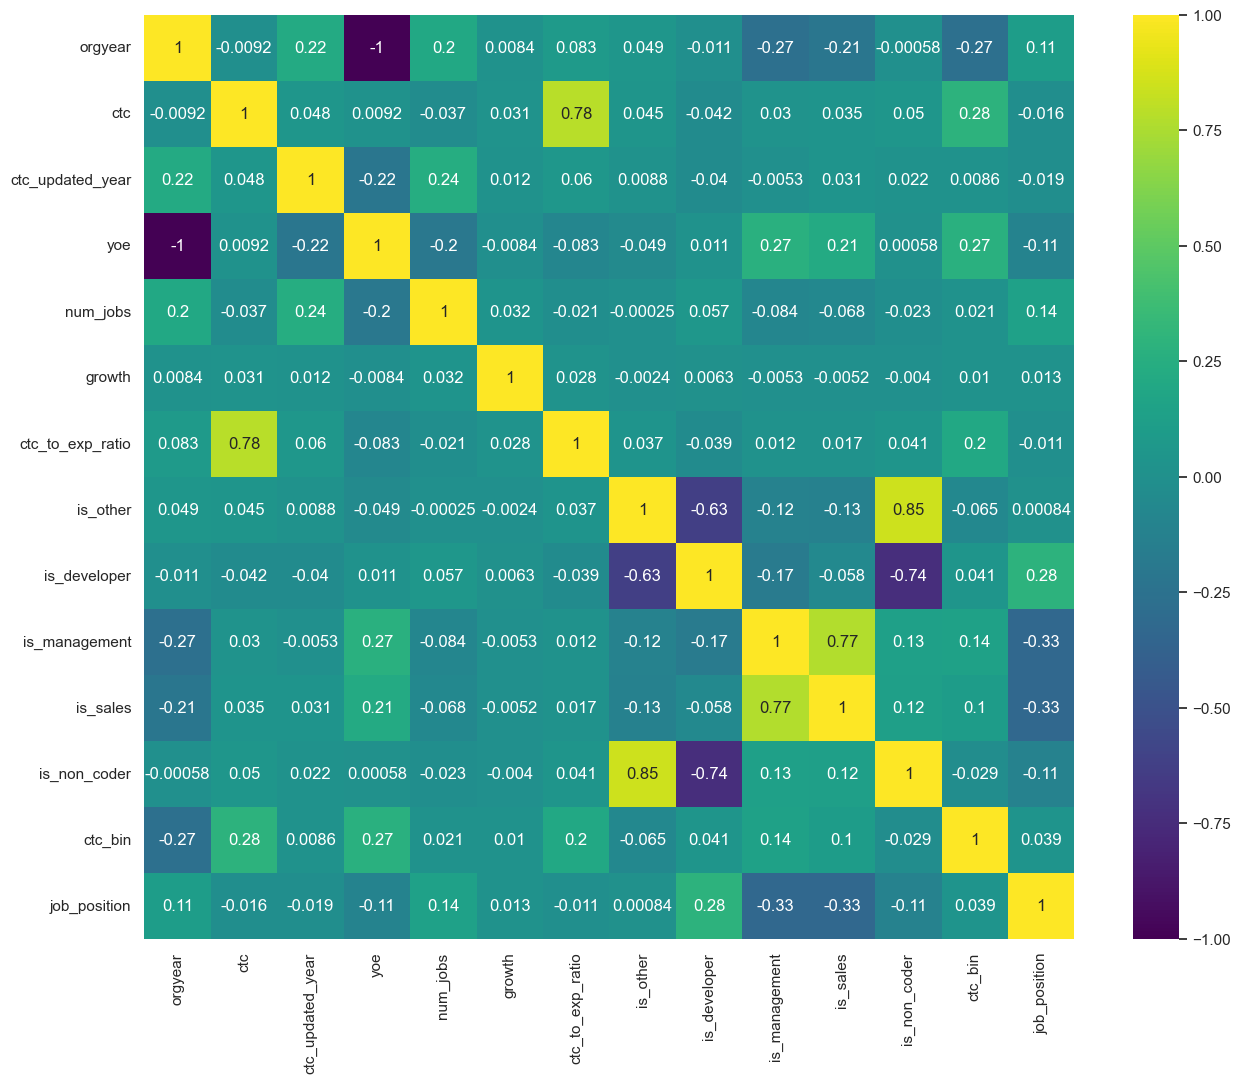

In [98]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="viridis", annot=True);

**Remove outliers using Local Outlier Factor**

In [63]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05).fit_predict(df.to_pandas())

In [64]:
df = df.with_columns(is_inlier=clf)
df["is_inlier"].value_counts()
df=df.filter(df["is_inlier"] == 1)

shape: (2, 2)
┌───────────┬───────┐
│ is_inlier ┆ count │
│ ---       ┆ ---   │
│ i64       ┆ u32   │
╞═══════════╪═══════╡
│ -1        ┆ 3410  │
│ 1         ┆ 64775 │
└───────────┴───────┘

In [65]:
X = df.to_pandas().drop(["is_inlier"], axis=1)

In [219]:
df.write_parquet("../data/processed/data_scaled.parquet")
X.to_parquet("../data/processed/X.parquet")

In [99]:
df=pl.read_parquet("../data/processed/data_scaled.parquet")
X=pd.read_parquet("../data/processed/X.parquet")

# Unsupervised Learning

**Hopkins Test to check the cluster tendency**

In [220]:
def hopkins_statistic(X, sample_size=0.1):
    n = X.shape[0] 
    m = int(sample_size * n) 

    random_indices = np.random.choice(np.arange(n), size=m, replace=False)
    X_sample = X.iloc[random_indices]

    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    X_uniform_random = np.random.uniform(X_min, X_max, (m, X.shape[1]))

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)

    u_distances, _ = nbrs.kneighbors(X_sample)
    u_distances = u_distances.sum()
    w_distances, _ = nbrs.kneighbors(X_uniform_random)
    w_distances = w_distances.sum()

    hopkins_stat = w_distances / (u_distances + w_distances)

    return hopkins_stat

In [221]:
hopkins_stat = hopkins_statistic(X)
print(f"Hopkins Statistic: {hopkins_stat}")

Hopkins Statistic: 1.0


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

From Hopkins test we can see that the data is not suitable for clustering

## K-Means Clustering

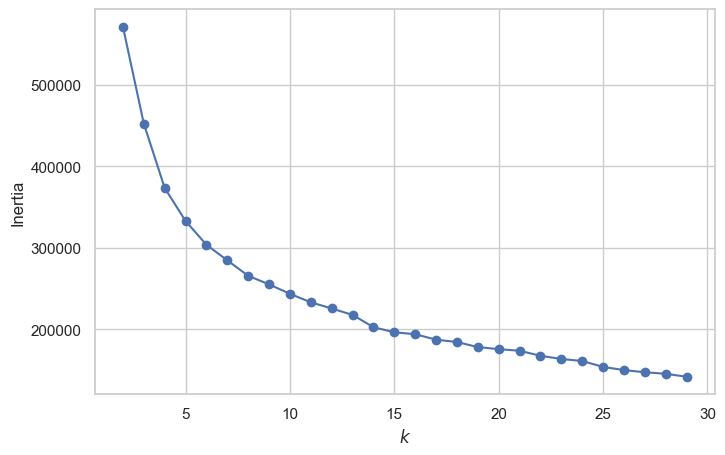

In [100]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(2, 30, 1)]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 5))
plt.plot(range(2, 30, 1), inertias, "-o")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We will use K=5 for K-means clustering due to the presence of slight elbow

**Using PCA to reduce the dimensions**

In [101]:
pca_explained_variance = PCA().fit(X).explained_variance_ratio_.cumsum()
pca_explained_variance

array([0.28207368, 0.48866291, 0.64811405, 0.75366195, 0.84304101,
       0.91929074, 0.94826786, 0.96800794, 0.98302944, 0.99222173,
       0.9969669 , 0.99893238, 1.        , 1.        ])

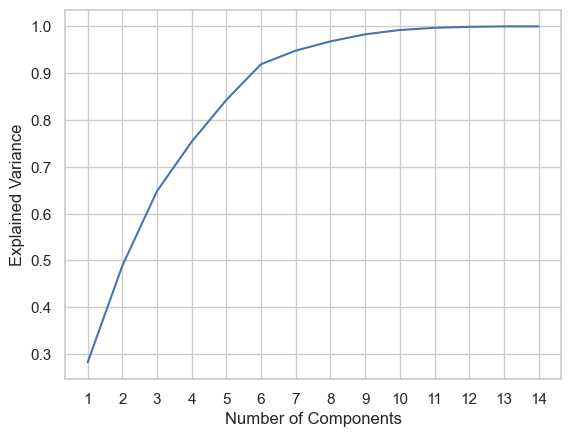

In [102]:
sns.lineplot(x=range(1, len(pca_explained_variance) + 1), y=pca_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

plt.xticks(range(1, len(pca_explained_variance) + 1))
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We will use 8 components as it explains 95% of the variance.

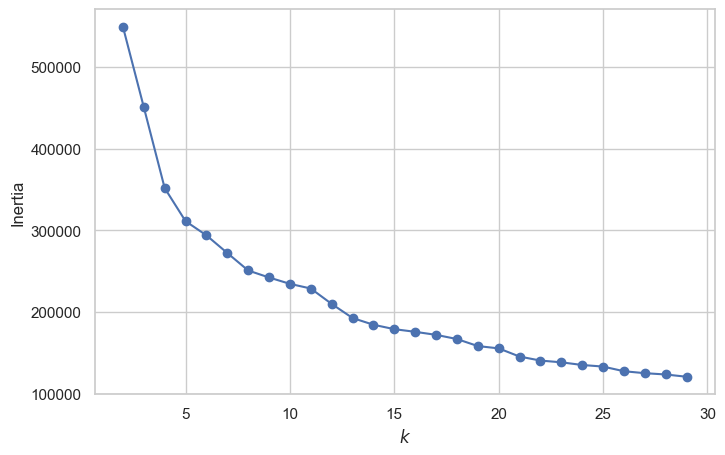

In [103]:
X_embedded_pca = PCA(n_components=8).fit_transform(X)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_embedded_pca)
                for k in range(2, 30, 1)]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 5))
plt.plot(range(2, 30, 1), inertias, "-o")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

From above plot we are not able to find the optimal number of clusters. But since there seems to be a slight elbow at 5, we can consider 5 clusters.

In [104]:
kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X_embedded_pca)
df=df.with_columns(
    y_kmeans=y_kmeans
)

In [113]:
df

shape: (64_775, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ orgyear   ┆ ctc       ┆ ctc_updat ┆ yoe       ┆ … ┆ ctc_bin   ┆ job_posit ┆ is_inlier ┆ y_kmeans │
│ ---       ┆ ---       ┆ ed_year   ┆ ---       ┆   ┆ ---       ┆ ion       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ i64       ┆ i32      │
│           ┆           ┆ f64       ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.343684  ┆ -0.182148 ┆ 1.123165  ┆ -0.343684 ┆ … ┆ -1.263878 ┆ -0.952538 ┆ 1         ┆ 0        │
│ 0.808337  ┆ -0.085829 ┆ -1.106929 ┆ -0.808337 ┆ … ┆ 0.40634   ┆ -1.120752 ┆ 1         ┆ 0        │
│ -0.817948 ┆ 0.105216  ┆ 1.123165  ┆ 0.817948  ┆ … ┆ 1.241448  ┆ -0.632186 ┆ 1         ┆ 3        │
│ -0.120969 ┆ -0.038068 ┆ 0.3798    ┆ 0.120969  ┆ … ┆ 1.241448  ┆ -0.1643   ┆ 1         ┆ 0        │
│ -2.908885 ┆ 0.129097  ┆ -0.363565 ┆ 2.908885  ┆ … ┆ 2.076557  ┆ -1.231019 ┆ 1         ┆ 3        │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ -0.353295 ┆ -0.101749 ┆ -0.363565 ┆ 0.353295  ┆ … ┆ 0.40634   ┆ -0.977017 ┆ 1         ┆ 2        │
│ 0.808337  ┆ -0.135182 ┆ -0.363565 ┆ -0.808337 ┆ … ┆ -0.428769 ┆ -1.078077 ┆ 1         ┆ 0        │
│ -2.676559 ┆ 0.081336  ┆ 1.123165  ┆ 2.676559  ┆ … ┆ 1.241448  ┆ -0.1643   ┆ 1         ┆ 3        │
│ 0.111358  ┆ 0.033574  ┆ 0.3798    ┆ -0.111358 ┆ … ┆ 1.241448  ┆ 1.420651  ┆ 1         ┆ 0        │
│ 0.808337  ┆ -0.118466 ┆ -0.363565 ┆ -0.808337 ┆ … ┆ -0.428769 ┆ -0.1643   ┆ 1         ┆ 0        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

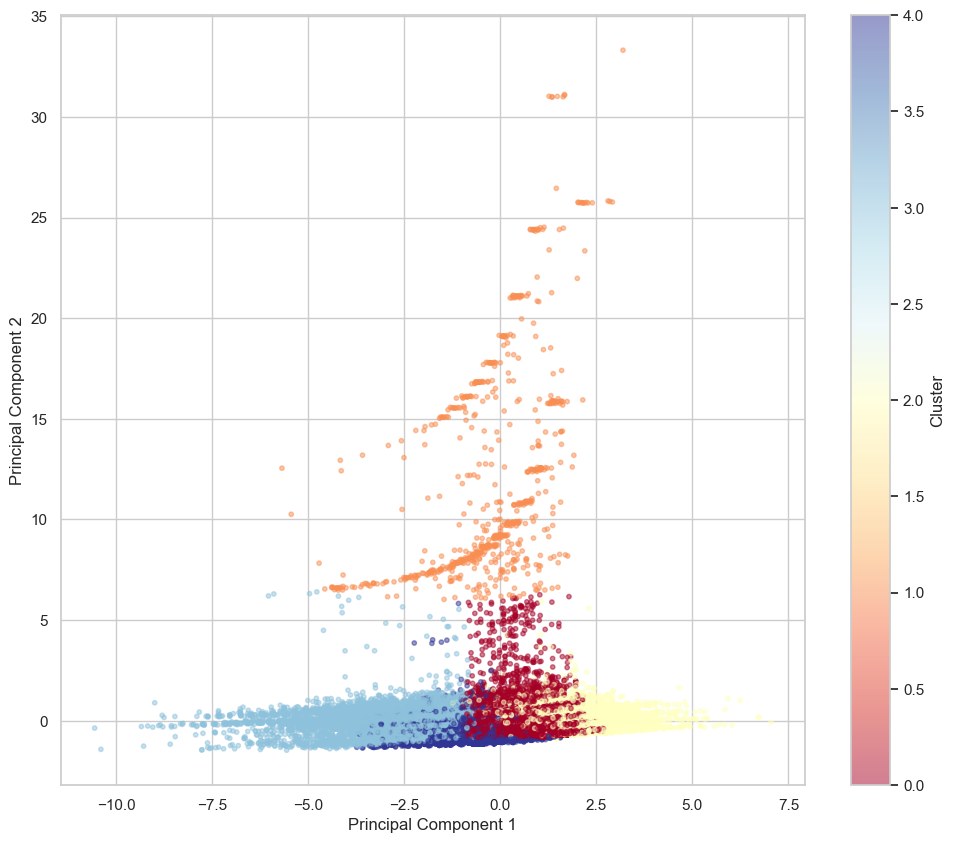

In [227]:
plt.figure(figsize=(12, 10))
scatter=plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=y_kmeans, s=10, cmap='RdYlBu', alpha=0.5 )
# add legend
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above clustering plot, we can see there is similarity between plot generated by manual clustering and k-means clustering.
- We can see that the clusters 1 is far from other clusters

In [105]:
def create_polar_plot(data, features, cluster_label):
    num_vars = len(features)

    # Compute angle of each axis (in radians)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is made in a circular (polar) form, so we need to "close the loop"
    data = np.concatenate((data, [data[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.fill(angles, data, color='blue', alpha=0.25)
    ax.plot(angles, data, color='blue', linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    plt.title(f'Cluster {cluster_label}', size=20, color='blue', y=1.1)

    plt.show();

def create_combined_polar_plot(normalized_means, features, cluster_labels):
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

    for i, data in enumerate(normalized_means):
        data = np.concatenate((data, [data[0]]))
        ax.fill(angles, data, alpha=0.25, label=f'Cluster {cluster_labels[i]}')
        ax.plot(angles, data, linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    plt.title('Cluster Comparison', size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()



### Cluster analysis

In [106]:
cluster_means = df.group_by("y_kmeans").mean().to_pandas().drop(["y_kmeans","is_inlier"], axis=1)

scaler = MinMaxScaler()
normalized_means = scaler.fit_transform(cluster_means)

In [107]:
cluster_means

orgyear       ctc  ctc_updated_year       yoe  num_jobs    growth  \
0 -1.918170  0.018687         -0.138136  1.918170 -0.209353 -0.010262   
1  0.376624 -0.069102          0.302020 -0.376624 -0.339155 -0.013919   
2 -0.327516 -0.089385         -1.855684  0.327516 -0.216063 -0.012841   
3  0.390229 -0.069585          0.562197 -0.390229  2.549371  0.065804   
4  0.120952  9.461221          0.444488 -0.120952 -0.258959 -0.005299   

   ctc_to_exp_ratio  is_other  is_developer  is_management  is_sales  \
0         -0.084150  0.076208      0.757585       0.296871  0.272362   
1         -0.038127  0.111660      0.740836       0.095240  0.111131   
2         -0.092348  0.107654      0.827551       0.059655  0.057636   
3         -0.046173  0.100049      0.828030       0.047318  0.067492   
4          7.738631  0.231563      0.597345       0.168142  0.196165   

   is_non_coder   ctc_bin  job_position  
0      0.144535  0.806881     -0.483044  
1      0.146267 -0.081313     -0.290874  
2      0.127111 -0.045168      0.197273  
3      0.114401  0.185543      0.132658  
4      0.299410  2.076557     -0.383857

In [108]:
cluster_means.columns.to_list()

['orgyear',
 'ctc',
 'ctc_updated_year',
 'yoe',
 'num_jobs',
 'growth',
 'ctc_to_exp_ratio',
 'is_other',
 'is_developer',
 'is_management',
 'is_sales',
 'is_non_coder',
 'ctc_bin',
 'job_position']

In [114]:
features =cluster_means.columns.to_list()

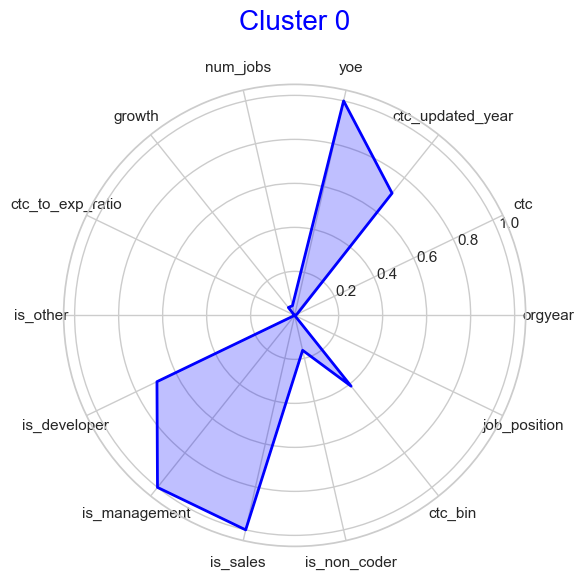

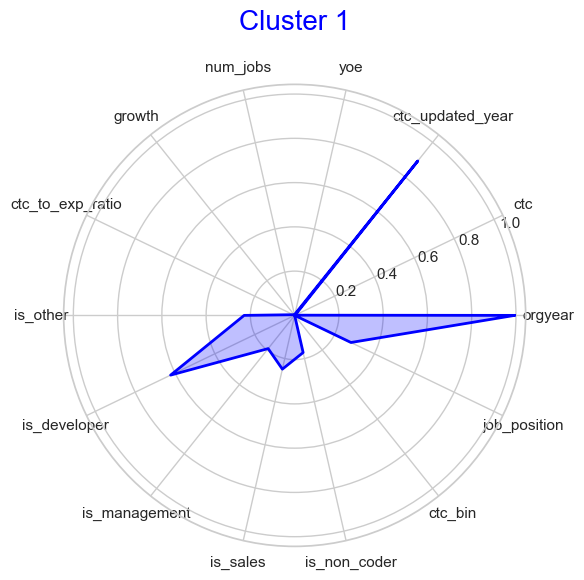

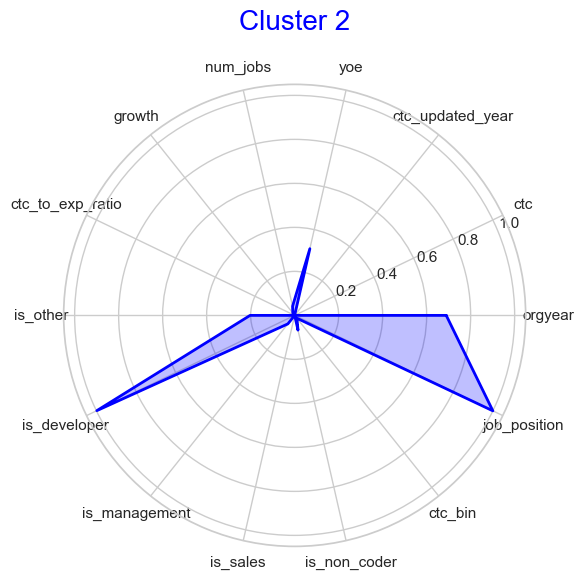

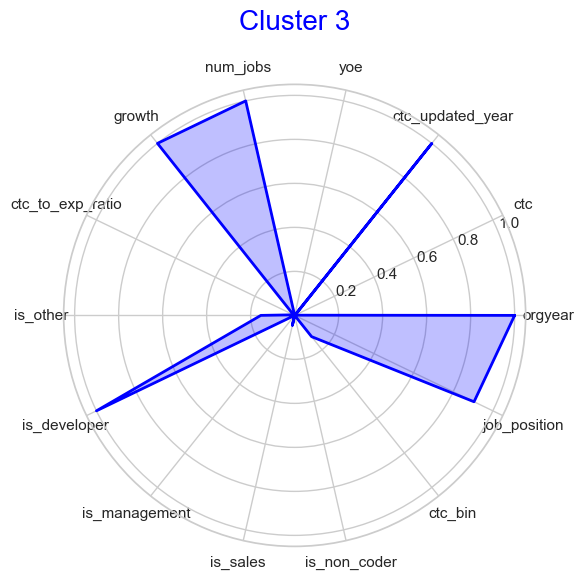

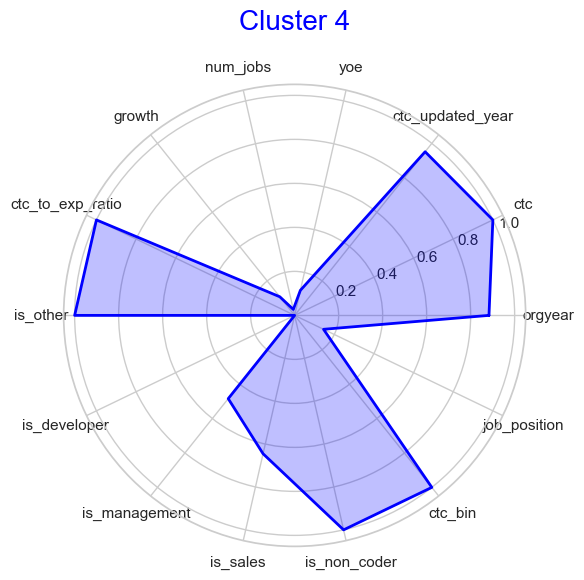

In [115]:
for cluster in range(cluster_means.shape[0]):
    create_polar_plot(normalized_means[cluster], features, cluster)

**Combined Polar Plot**

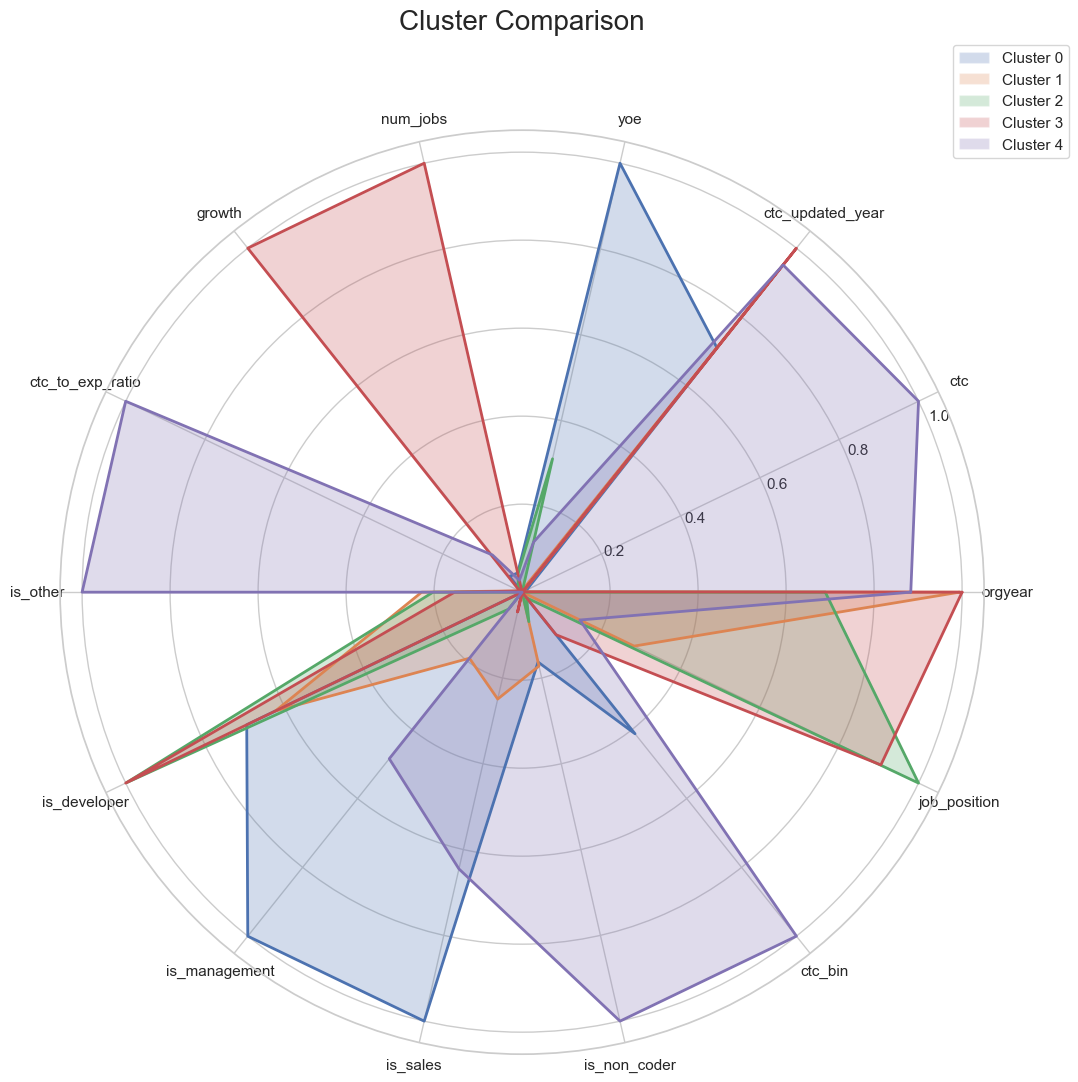

In [111]:
cluster_labels = df["y_kmeans"].unique().to_list()
create_combined_polar_plot(normalized_means, features, cluster_labels)

**Cluster 0**   
Candidates in this cluster belong to the management and sales category and have higher experience.

**Cluster 1**   
Candidates in this cluster have  lower experience. Also they belong developers category and have joined recently

**Cluster 2**   
Candidates in this cluster belong to developer category and have lower experience

**Cluster 3**   
Candidates in this belong to developer category and have switched jobs multiple times

**Cluster 4**    
Candidates in this cluster belong to non coder category and have higher ctc 

**Plotting clusters using UMAP**

In [29]:
X_embedded_tsne = umap.UMAP().fit_transform(X)

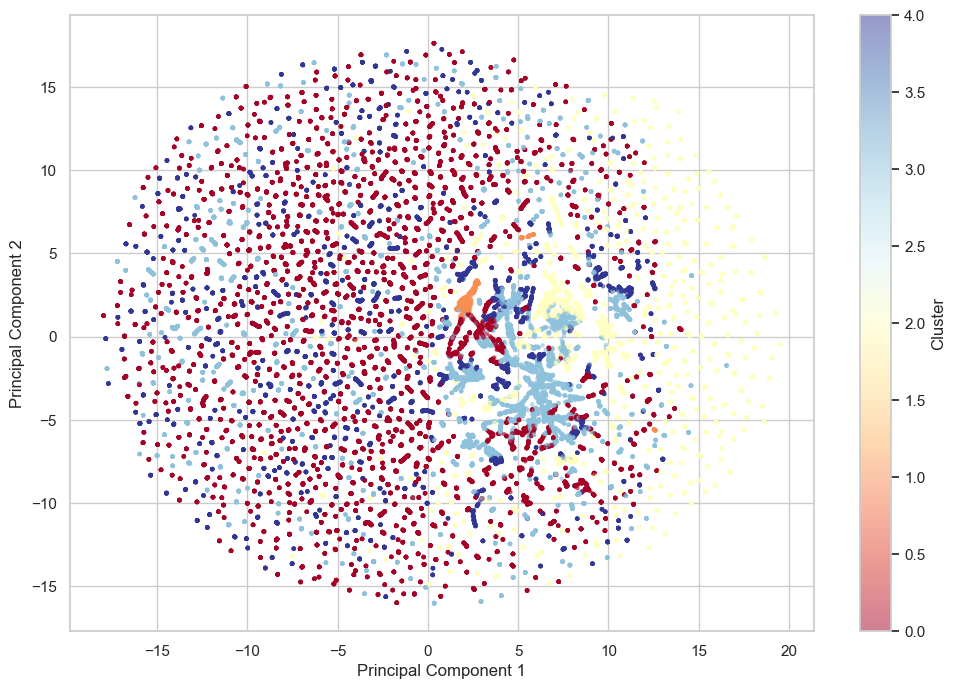

In [237]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_tsne[:, 0], X_embedded_tsne[:, 1], c=y_kmeans, s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

## Hierarchical Clustering

In [3]:
X_embedded_pca = PCA(n_components=8).fit_transform(X)

In [4]:
sample = pd.DataFrame(X_embedded_pca).sample(frac=0.9, random_state=42)

In [5]:
sample_hc = X.loc[sample.index]

In [6]:
sample_hc

orgyear       ctc  ctc_updated_year       yoe  num_jobs    growth  \
22086  0.343684 -0.173391         -0.363565 -0.343684 -0.339155 -0.013919   
34847  0.576010 -0.117670          1.123165 -0.576010 -0.339155 -0.013919   
40754  0.576010 -0.196794         -0.363565 -0.576010 -0.339155 -0.013919   
30258 -0.120969 -0.180078         -2.593659  0.120969 -0.339155 -0.013919   
8006   0.808337 -0.154287          1.123165 -0.808337  1.926407 -0.013919   
...         ...       ...               ...       ...       ...       ...   
30453  0.343684 -0.128814         -0.363565 -0.343684 -0.339155 -0.013919   
59128  0.808337 -0.141550          1.123165 -0.808337 -0.339155 -0.013919   
30257 -0.120969 -0.074685         -2.593659  0.120969 -0.339155 -0.013919   
35595  0.343684 -0.189312         -1.106929 -0.343684 -0.339155 -0.013919   
22164  0.576010 -0.046028          1.123165 -0.576010 -0.339155 -0.013919   

       ctc_to_exp_ratio  is_other  is_developer  is_management  is_sales  \
22086         -0.125601         0             1              0         0   
34847         -0.079277         0             0              1         1   
40754         -0.140672         1             0              0         0   
30258         -0.132704         0             1              0         0   
8006          -0.099351         1             0              0         0   
...                 ...       ...           ...            ...       ...   
30453         -0.096777         0             1              0         0   
59128         -0.086998         0             1              0         0   
30257         -0.081593         0             0              1         1   
35595         -0.135896         0             1              0         0   
22164         -0.023688         0             1              0         0   

       is_non_coder   ctc_bin  job_position  
22086             0 -1.263878     -0.862877  
34847             0 -0.428769     -1.269674  
40754             1 -1.263878     -0.164300  
30258             0 -1.263878     -0.632186  
8006              1 -1.263878     -0.164300  
...             ...       ...           ...  
30453             0 -0.428769     -1.121263  
59128             0 -0.428769     -0.952538  
30257             1  0.406340     -1.230215  
35595             0 -1.263878      0.262518  
22164             0  1.241448     -0.862877  

[58298 rows x 14 columns]

**Build Linkage Matrix**

In [7]:
%%time
Z = fastcluster.linkage(sample, method='ward')

CPU times: user 3min 33s, sys: 9min 3s, total: 12min 36s
Wall time: 22min 46s


In [13]:
import pickle
# with open("../models/hierarchical_clustering.pkl", "wb") as f:
#     pickle.dump(Z, f)

with open("../models/hierarchical_clustering.pkl", "rb") as f:
    Z = pickle.load(f)

**Plot Dendrogram**

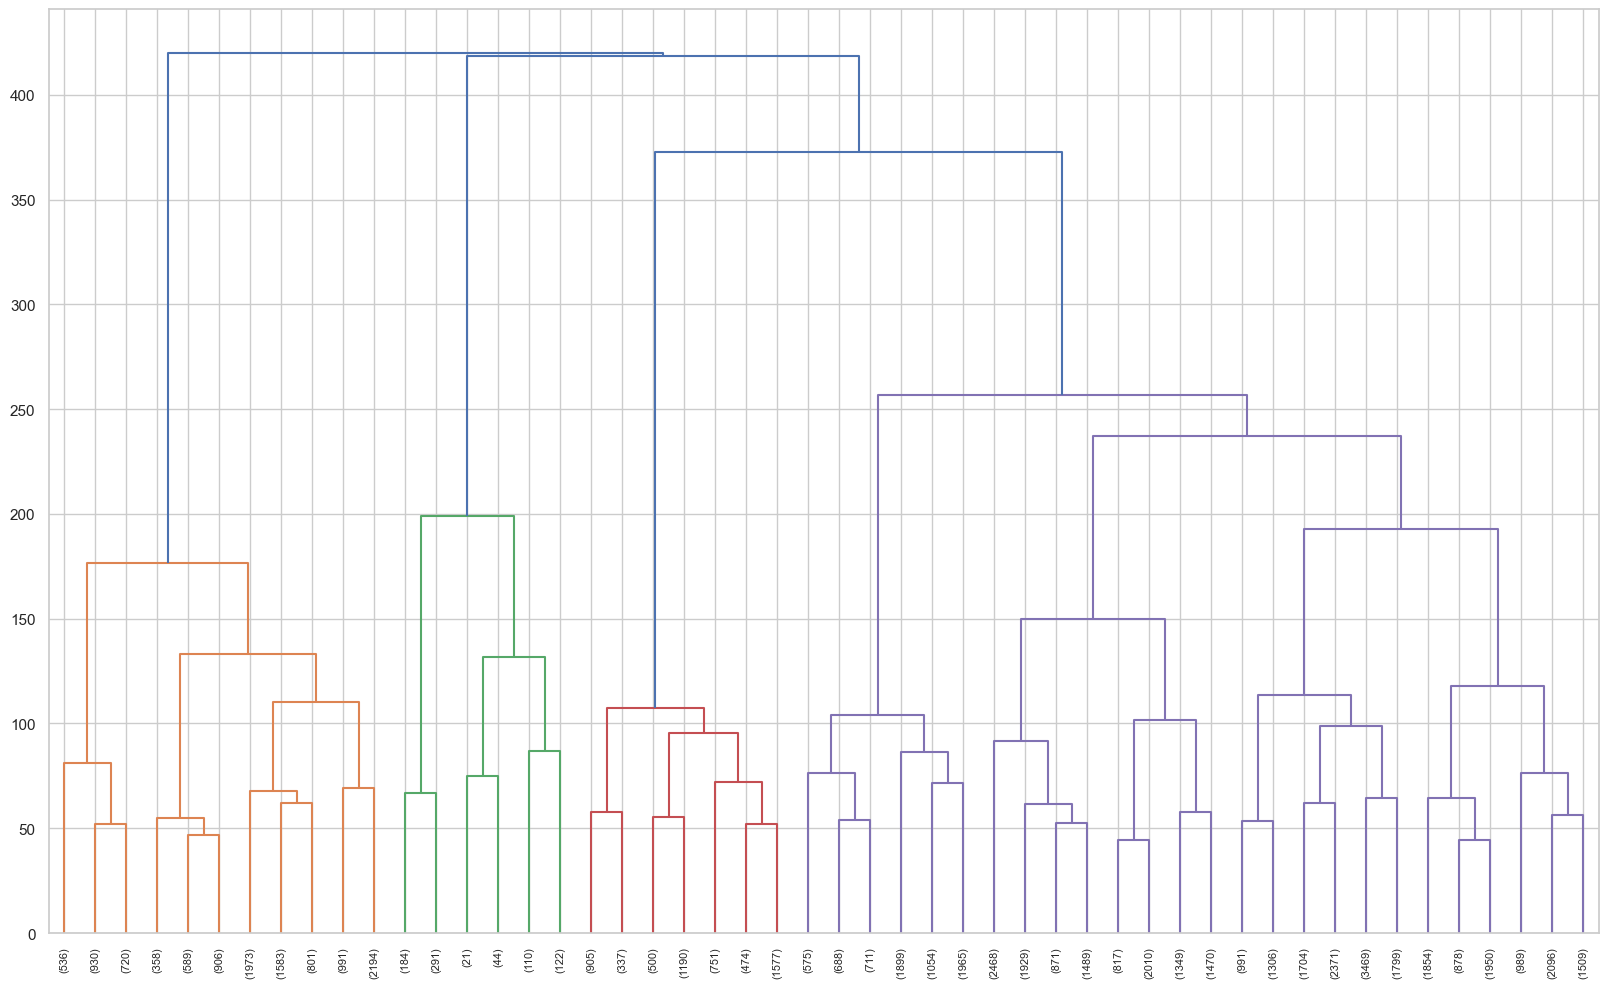

In [9]:
fig, ax = plt.subplots(figsize=(20, 12))
dendrogram( Z, truncate_mode='lastp', p=50);

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We will cut the dendrogram at 250 which will give us 5 clusters.

In [14]:
sample_hc["cluster"] = fcluster(Z, 5, criterion='maxclust')

**Plotting Hierarchical Clusters**

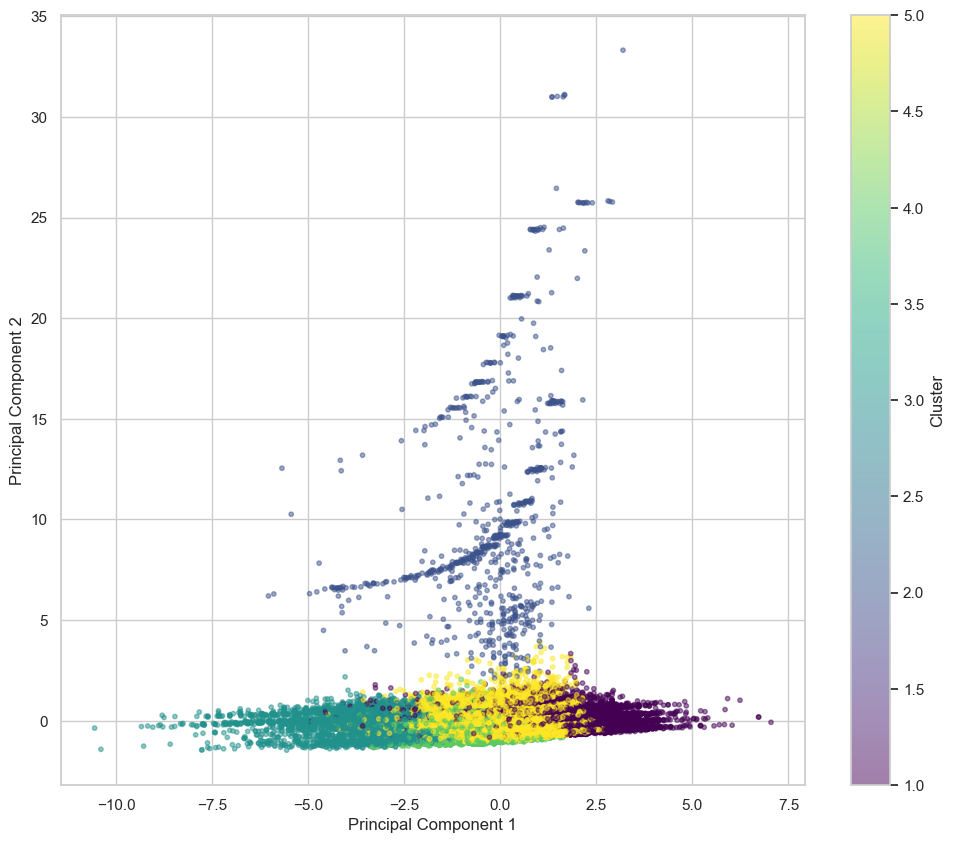

In [12]:
plt.figure(figsize=(12, 10))
scatter=plt.scatter(sample.iloc[:, 0], sample.iloc[:, 1], c=sample_hc["cluster"], s=10, cmap='viridis', alpha=0.5 )
# add legend
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that the clusters are not well defined.
- Cluster 1 

**Plotting clusters using UMAP**

In [30]:
X_embedded_tsne = umap.UMAP().fit_transform(sample)

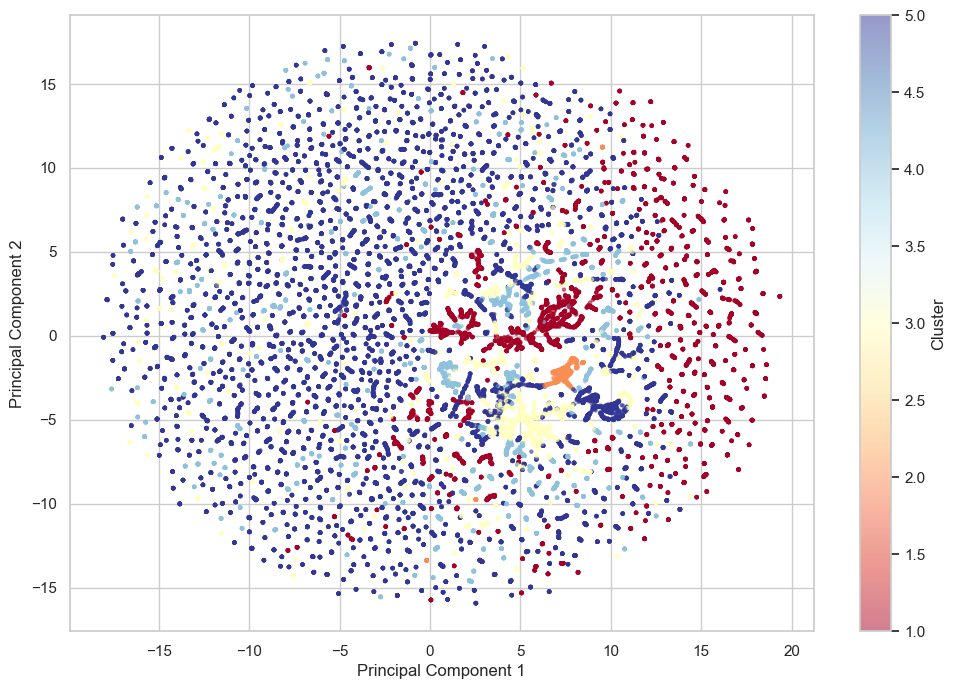

In [31]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_tsne[:, 0], X_embedded_tsne[:, 1], c=sample_hc["cluster"] , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

### Cluster Analysis

In [18]:
cluster_means = sample_hc.groupby("cluster").mean()
scaler = MinMaxScaler()
normalized_means = scaler.fit_transform(cluster_means)
features =cluster_means.columns.to_list()

In [23]:
cluster_means

orgyear       ctc  ctc_updated_year       yoe  num_jobs    growth  \
cluster                                                                       
1        0.273551 -0.064851          0.564342 -0.273551  2.519354  0.064651   
2        0.109853  8.087376          0.400021 -0.109853 -0.245246  0.001319   
3       -2.559585  0.003628         -0.363954  2.559585 -0.322561 -0.013919   
4       -0.310585 -0.086293         -2.179157  0.310585 -0.138963 -0.010967   
5        0.073830 -0.075520          0.141434 -0.073830 -0.339155 -0.013919   

         ctc_to_exp_ratio  is_other  is_developer  is_management  is_sales  \
cluster                                                                      
1               -0.049069  0.099042      0.826008       0.060357  0.079009   
2                6.560484  0.303109      0.553109       0.148964  0.181347   
3               -0.097548  0.034705      0.783572       0.372864  0.328392   
4               -0.090778  0.165264      0.722867       0.102438  0.094312   
5               -0.060270  0.098652      0.769381       0.101474  0.114109   

         is_non_coder   ctc_bin  job_position  
cluster                                        
1            0.116657  0.227506      0.105622  
2            0.356218  2.076557     -0.348436  
3            0.117021  0.700973     -0.480073  
4            0.200087 -0.002248     -0.330149  
5            0.131727  0.049653     -0.172190

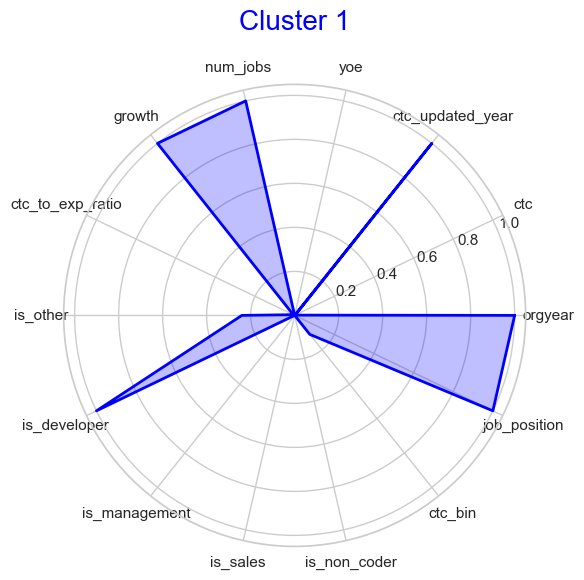

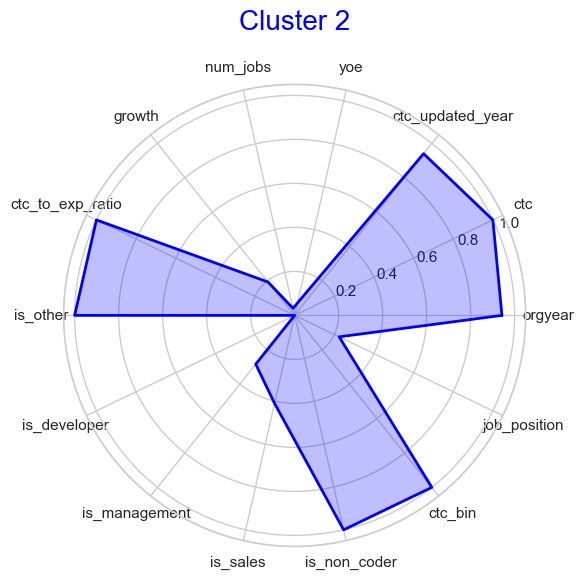

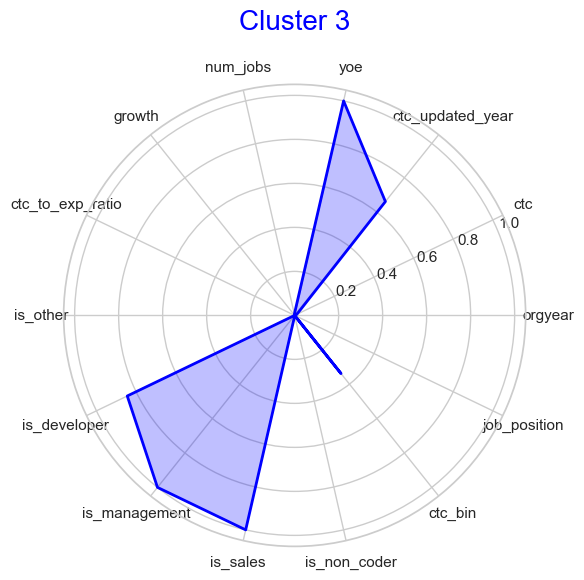

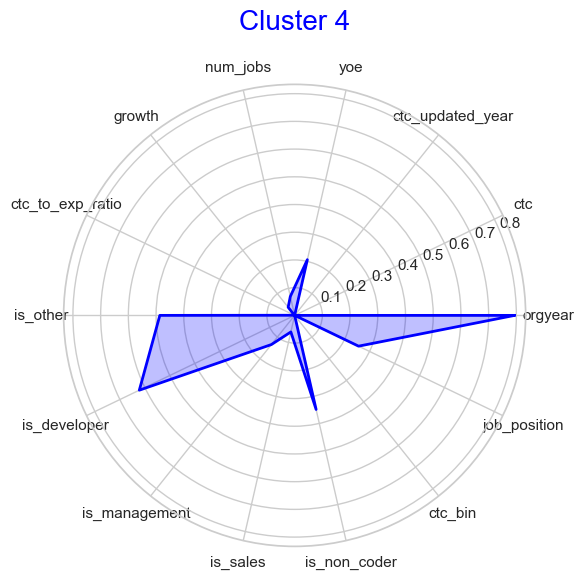

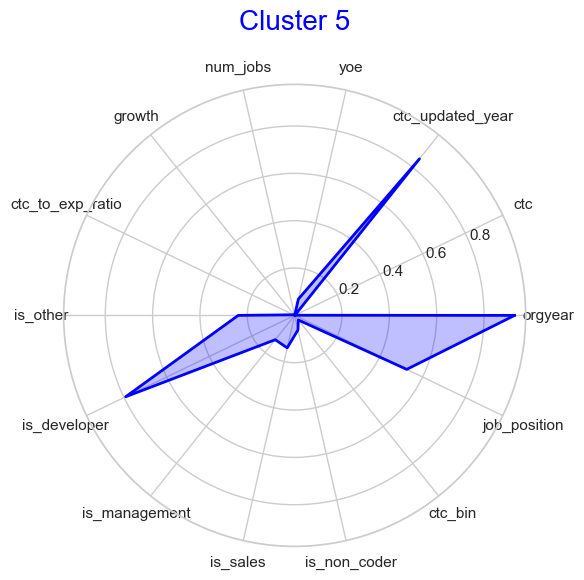

In [22]:
for cluster in range(cluster_means.shape[0]):
    create_polar_plot(normalized_means[cluster], features, cluster+1)

**Combined Polar Plot**

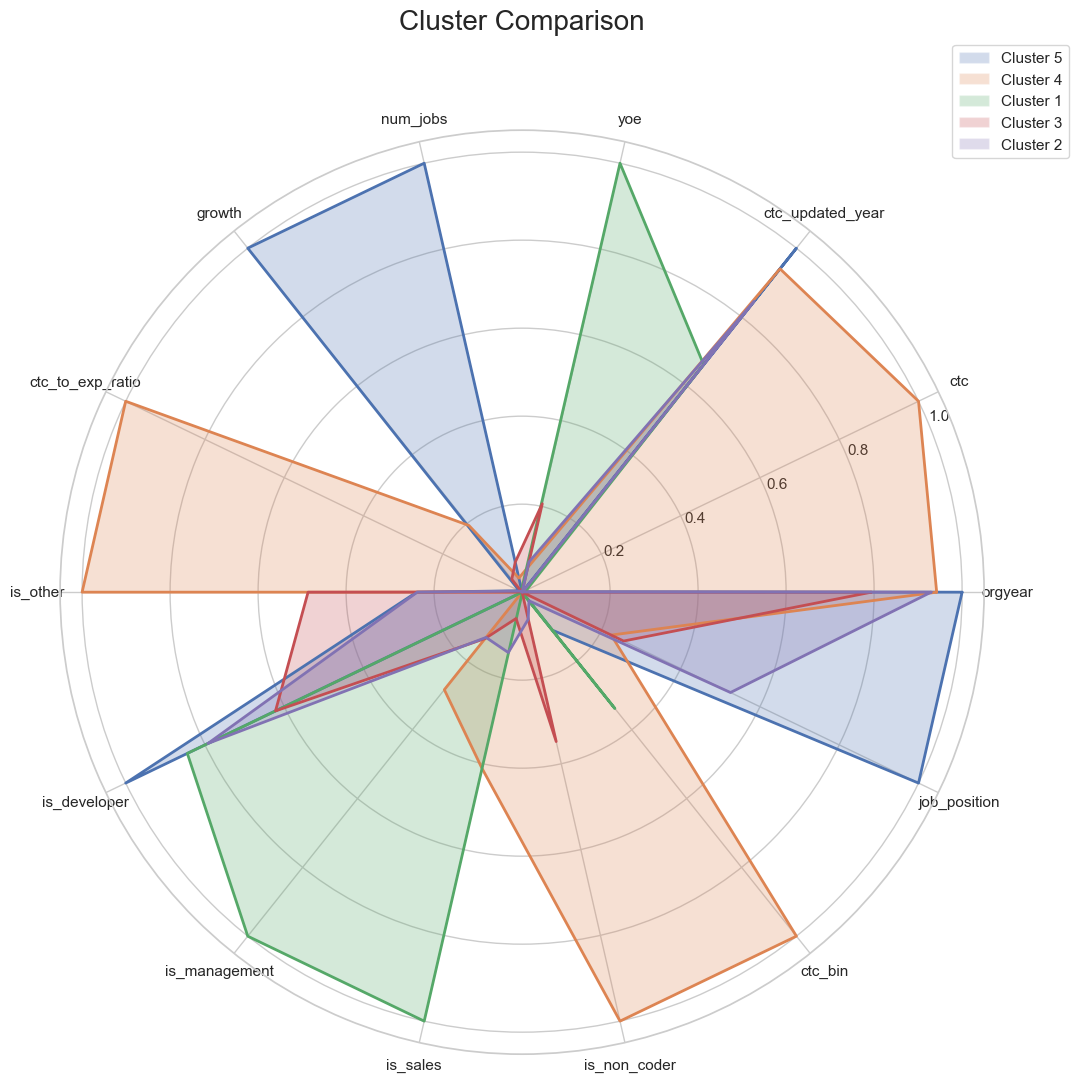

In [19]:
cluster_labels = sample_hc["cluster"].unique()
create_combined_polar_plot(normalized_means, features, cluster_labels)

**Cluster 1**  
Candidates in this cluster belong to developers category, and have higher number of job switches.

**Cluster 2**  
Candidates in this cluster belong to the non coder category with high ctc

**Cluster 3**  
Candidates in this cluster have higher experience and belong to management category along with technical skills.

**Cluster 4**  
Candidates in this cluster have  lower experience. Also they belong developers category

**Cluster 5**    
Candidates in this cluster have recently got hike and belong to developer category

In [15]:
sample_hc.to_parquet("../data/processed/sample_hc.parquet")

In [116]:
sample_hc = pd.read_parquet("../data/processed/sample_hc.parquet")

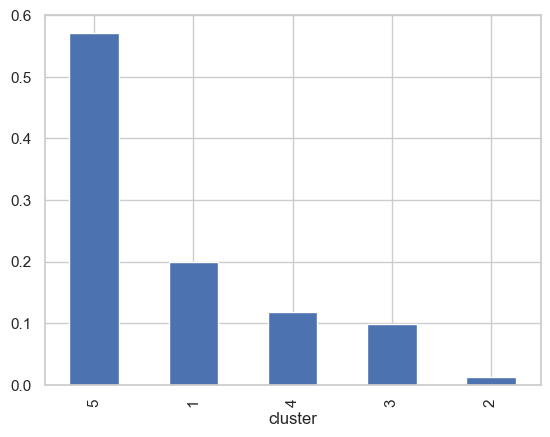

In [36]:
sample_hc["cluster"].value_counts(normalize=True).plot(kind="bar");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that cluster 5 containing developers has the highest count and cluster 2 containing non coders has the lowest count.
- More than 50% of the candidates belong to cluster 5.

**Year of experience density plot for each cluster**

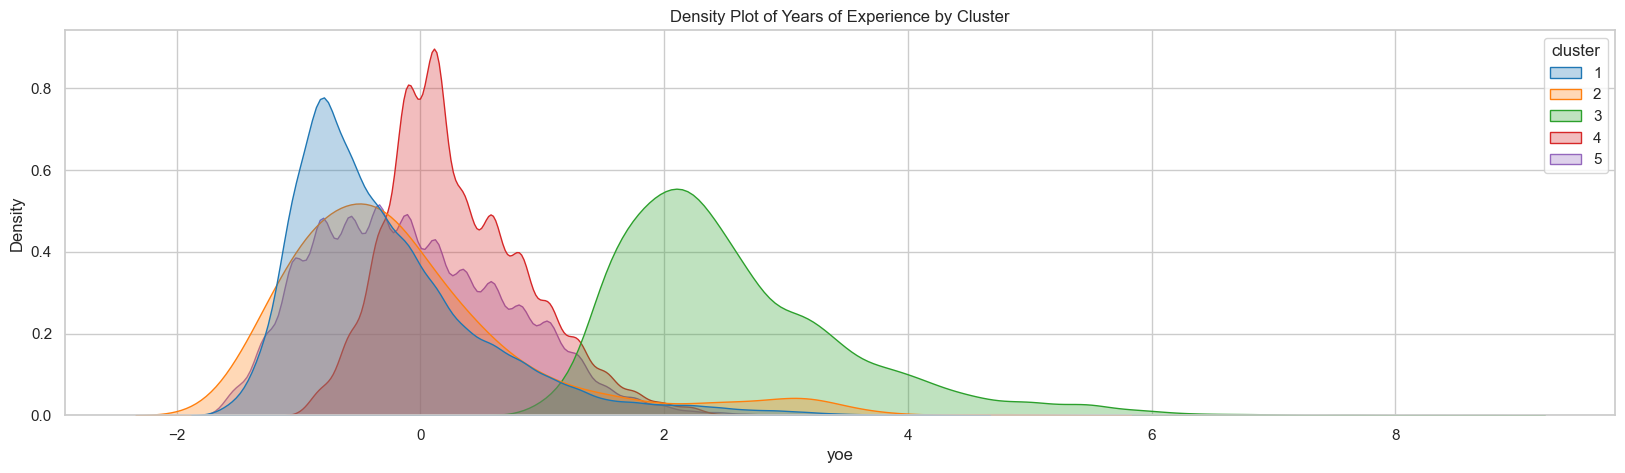

In [50]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=sample_hc, x="yoe", hue="cluster", cbar=True, fill=True, common_norm=False, alpha=0.3,  palette="tab10");
plt.title("Density Plot of Years of Experience by Cluster");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that Cluster 3 containing management employees have higher experience

# Insights and Recommendations


- There are 153443 candidates 37299 companies in the dataset
- Most of the candidates have under 10 years of experience.
- The majority of the CTC has been updated from 2019 to 2021.
- Most of the candidates joined after 2010
- The job position of "engineering intern" has unusually very high CTC
- Majority of candidates have  CTCs  between 6 to 16 lakhs
- Most of the candidates belong to the Web development domain specifically backend development
- The mean CTC is around 12 lakhs and the median is around 10 lakhs.
- The backend architect has the highest average CTC.
- QA engineer has decreasing trend in CTC over the years as experience has increased
- In the majority of the cases Data Scientist has higher average CTC than other job positions. But the gap is not that significant.
- Most of the candidates in the dataset belong to the tier 1 flag, indicating that these candidates have higher than average CTC.

- We can see that most Tier 3 candidates do not switch companies.
- There is a huge variance in CTC concerning experience for tier 3 candidates.

- We can also see that sales CTC decreases after 15 years of experience.
The majority of the sales have less than 5 lakhs CTC.
- Developers have a wide range of salaries for different experience levels.
- There are 5 clusters in the dataset.
The majority of the candidates belong to cluster 5 which contains developers amounting to more than 50% of the candidates.

## Cluster Insights

### Manual Clustering

- Manual clustering and unsupervised clustering had the same cluster shapes when plotted in 2d.


### Kmeans Clustering

- **Cluster 0**   
Candidates in this cluster belong to the management and sales category and have higher experience.

- **Cluster 1**   
Candidates in this cluster have less experience. Also, they belong developers category and have joined recently.

- **Cluster 2**   
Candidates in this cluster belong to the developer category and have less experience

- **Cluster 3**   
Candidates in this belong to the developer category and have switched jobs multiple times.

- **Cluster 4**    
Candidates in this cluster belong to non-coder category and have higher ctc 


### Hierarchical Clustering

- **Cluster 1**  
Candidates in this cluster belong to the developers category and have a higher number of job switches.

- **Cluster 2**  
Candidates in this cluster belong to the non-coder category with high ctc

- **Cluster 3**  
Candidates in this cluster have higher experience and belong to the management category along with technical skills.

- **Cluster 4**  
Candidates in this cluster have less experience. Also, they belong developers category.

- **Cluster 5**    
Candidates in this cluster have recently got a hike and belong to the developer category


## Recommendation wrt to candidates
- The company should focus on these candidates as they are the majority.
- The company should push junior candidates towards backend development roles as they have the highest average CTC
- The company should push mid-level candidates towards management roles. 
- Alternatively, if mid-level candidates are very good at technical skills, they can be pushed towards technical management roles.
- There are very few non-coders in the dataset which can be pushed to intern roles

## Clustering Algorithm Comparison
- Hierarchical clustering seems to be a better fit for this dataset as it is able to capture the clusters better than K-means clustering. The only caveat is that it is slower than K-means clustering.
- If the dataset is large, then K-means clustering is a better fit as it is faster than Hierarchical clustering.

## Data Collection Recommendations
- The company has to capture data properly. The CTC is incorrect where candidates have put single-digit CTCs assuming the field to be in lakhs. This has to be corrected by adding validation checks.
- The job position field has to be corrected as there were many spelling mistakes, and in some cases, there were Pune, Jharkhand and Zomato as job positions which is incorrect. 
- This can be fixed by providing a dropdown list of job positions to the candidates along with a text field.